In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable
import seaborn as sns

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv("data/movement-speeds-daily-san-francisco-2020-3.csv")

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

Since we are looking at a uniform rectangular slice, we can take the average of speeds at all the longtidues and latitudes that fall within that slice, so it's convenient to spatially divide area using pluscodes. However, they disregards the traffic flow and do not capture much about the subpopulations since the divisions between neighborhoods, highways, intersections, etc... are abitrary. 
Before completing this section, we expected pluscodes to not be as accurate as some other method that perhaps takes demographic or divisions between neighborhoods into account.
Because of that, it turns out that pluscodes are not too effective at summarizing traffic speeds since they have a high variation between and within each slice.

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r"<node.id=.(\d+). lat=.(.\d+.\d+). lon=.(.\d+.\d+)..+>"

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.merge(node_to_gps, how="inner", 
                                      left_on="osm_start_node_id",
                                      right_on="osm_node_id")
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194
...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206


In [10]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
speeds_to_gps["plus_latitude_idx"] = speeds_to_gps["Latitude"]//0.012
speeds_to_gps["plus_longitude_idx"] = speeds_to_gps["Longitude"]//0.012

speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,3139.0,-10200.0
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,3139.0,-10200.0
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,3139.0,-10200.0
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,3139.0,-10200.0
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,3139.0,-10200.0
...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126,3144.0,-10209.0
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763,3135.0,-10202.0
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206,3144.0,-10209.0
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206,3144.0,-10209.0


In [12]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = len(speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).agg("mean"))
num_pluscode_regions

276

In [14]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



The histogram is skewed to the right and the average variance turned out to be ~8.7 mph. The average standard deviation in the whole dataset is higher: ~10.1 mph. While subdividing regions and analyzing traffic by pluscodes did decrease average variance (-8.7 mph variance seems somewhat reasonable, as most people driving on streets tend to stray from the posted speed by about 5-10mph), pluscodes still may not be the best method for analyzing traffic. Due to pluscodes being arbitrary with the way they capture traffic, as they divide regions based solely on latitude and longitude, they may not accurately capture subpopulations. In other words, they do not take into account the divisions between neighborhoods and highways, intersections, etc...which all contribute to the the average speed in that location. This might be why we observe speed variance as high as 15 more commonly than we do in the census tract subdivision method.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

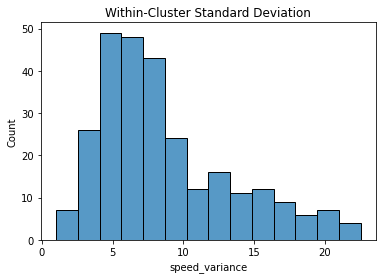

In [15]:
speed_variance_by_pluscode = speeds_to_gps[["speed_mph_mean", "plus_latitude_idx", "plus_longitude_idx"]].groupby(["plus_latitude_idx", "plus_longitude_idx"]).agg('std').reset_index().rename(columns = {"speed_mph_mean": "speed_variance"})
sns.histplot(speed_variance_by_pluscode, x = "speed_variance")
plt.title("Within-Cluster Standard Deviation")
average_variance_by_pluscode = speed_variance_by_pluscode["speed_variance"].mean()
variance_average_by_pluscode = speeds_to_gps[["speed_mph_mean", "plus_latitude_idx", "plus_longitude_idx"]].groupby(["plus_latitude_idx", "plus_longitude_idx"]).agg('mean').reset_index()["speed_mph_mean"].std()


<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [16]:
speed_variance_by_pluscode

,plus_latitude_idx,plus_longitude_idx,speed_variance
0,3128.0,-10210.0,3.650232
1,3128.0,-10198.0,20.704487
2,3128.0,-10194.0,12.342234
3,3129.0,-10210.0,4.083821
4,3129.0,-10199.0,21.390912
...,...,...,...
271,3160.0,-10198.0,15.293632
272,3160.0,-10197.0,17.915911
273,3160.0,-10196.0,14.243592
274,3160.0,-10195.0,12.237229


In [17]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [18]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [19]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [20]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps,
                                     geometry = gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude))
speeds_to_points.crs = tract_to_gps.crs
speeds_to_tract = speeds_to_points.sjoin(tract_to_gps)

speeds_to_tract

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,3139.0,-10200.0,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416605,110424354,110424978,6,12.834000,110424354,37.896700,-122.539525,3158.0,-10212.0,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
416606,110424354,110424978,7,15.586000,110424354,37.896700,-122.539525,3158.0,-10212.0,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
416607,110424354,110424978,10,13.255000,110424354,37.896700,-122.539525,3158.0,-10212.0,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
417028,110383033,110424972,7,19.423000,110383033,37.898306,-122.539984,3158.0,-10212.0,POINT (-122.53998 37.89831),498,499,"600 Throckmorton Avenue, Mill Valley"


In [21]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [22]:
speeds_by_tract = speeds_to_tract.groupby("DISPLAY_NAME").agg('mean')
num_census_tracts = speeds_by_tract.shape[0]

num_census_tracts

295

In [23]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



The average variance by tract is ~8.3 mph, which is lower than the average variance by pluscode. Also, the varaince of the average speeds in the whole dataset is ~8.34, which is close to the average variance by tract. This shows that the tracts are representative of the subpopulations as they take into account the populations in that geographical space and areas without street addresses, covering the more rural/suburban outkirts areas. Also, we see that the histogram is skewed to the right, with most variances falling under the  5-10 mph; this may be justified by the fact that some people tend to drive 5-10 miles faster/slower than the posted speed. Given the overall context, the average standard deviation is not high.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

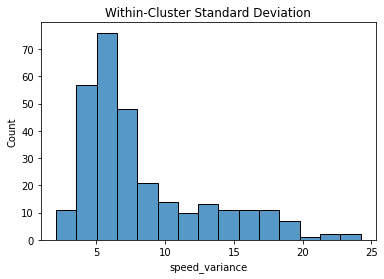

In [24]:
speed_variance_by_tract = speeds_to_tract[["speed_mph_mean", "DISPLAY_NAME"]].groupby("DISPLAY_NAME").agg('std').reset_index().rename(columns = {"speed_mph_mean": "speed_variance"})
sns.histplot(speed_variance_by_tract, x = "speed_variance")
plt.title("Within-Cluster Standard Deviation")
average_variance_by_tract = speed_variance_by_tract["speed_variance"].mean()
variance_average_by_tract = speeds_to_tract[["speed_mph_mean", "DISPLAY_NAME"]].groupby("DISPLAY_NAME").agg('mean').reset_index()["speed_mph_mean"].std()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [25]:
speed_variance_by_tract

,DISPLAY_NAME,speed_variance
0,"0 16th Avenue, Hayward Park, San Mateo",8.614906
1,"0 Avoca Alley, West of Twin Peaks, San Francisco",5.267842
2,"0 Bass Court, Bayview, San Francisco",4.190154
3,"0 Berkeley Way, Diamond Heights, San Francisco",7.834750
4,"0 Bernard Street, Nob Hill, San Francisco",3.565501
...,...,...
290,"Old Guadalupe Trail, Daly City",10.560797
291,"Old Sled Trail, Bolinas",14.971625
292,"Petrolite Street, Richmond",18.473868
293,"Regatta Boulevard, Marina Bay, Richmond",19.341401


In [26]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

We can assess which spatial structure allows for easier calcuation of neighboring distances; for instance, a hexgaon does not have as many neighboring distances as a square, which requires multiple set of coefficients for tracking due to having two different types of neighbors, one sharing an edge and the other a vertex. H3 can be considered a good spatial structure because it keeps track of the spatial area in a simple manner and is consistent with how it defines each area: a hexagon of the same size. On the other hand, postal codes would be a bad spatial structure because it would localize area into unusual shapes and these areas are subject to change, which is problematic. TAZ, though does not have uniform slices, takes into account demographic information, so it may be better at capturing subpopulations more accurately.

So overall, it is important to be consistent with how each area is defined, so it's easier to add/modify areas in the future, and simplify performing analyses and smoothing over gradients. Moreover, to better capture the subpopulations, it may be useful to incorporate demographics for each slice. Additionally, we can use the variance of speed within each slice/hexagon/space to measure how well the slices capture subpopulations.

Above, we’ve defined our metrics as variance of speed and consistency of slices. To optimize variance of speed (decrease them), we would want to decrease the size of slices. For example, when comparing the census tracts and the plus codes, we found that the average variance for census tracts was lower. The census tracts were smaller than plus codes; they subdivided the plus codes.

To optimize the consistency of shapes, we can make the area more uniform for census tracts (like the pluscodes) and use a shape, such as a hexagon (like Uber’s H3) because that allows for more scalablility and easier analysis. We can also add demograpahic features, such as the number of cars each house has, to better understand the subpopulation and thus estimate traffic flow.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

Our hypothesis is that the high speed traffic corresponds to the highways/freeways in San Francisco, and not the regular streets running through the city, because speeds are usually highest on highways._Type your answer here, replacing this text._

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [27]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
averages_pre = speeds_to_tract[speeds_to_tract["day"].isin(list(np.arange(1, 14)))]
averages_pre = averages_pre.groupby("DISPLAY_NAME").agg("mean")["speed_mph_mean"]
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = speeds_to_tract[speeds_to_tract["day"].isin(list(np.arange(1, 14)))].groupby("DISPLAY_NAME").agg("mean")
averages_pre_named

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,index_right,MOVEMENT_ID
DISPLAY_NAME,,,,,,,,,,,
"0 16th Avenue, Hayward Park, San Mateo",8.902570e+08,1.020688e+09,6.451220,24.634522,8.902570e+08,37.548520,-122.323967,3128.597561,-10194.000000,2453.0,2454.0
"0 Avoca Alley, West of Twin Peaks, San Francisco",5.821033e+08,6.198284e+08,6.623719,20.533727,5.821033e+08,37.736784,-122.445822,3144.147877,-10204.234261,1294.0,1295.0
"0 Bass Court, Bayview, San Francisco",1.284177e+09,1.771809e+09,7.099291,17.625693,1.284177e+09,37.731329,-122.383105,3144.000000,-10199.000000,301.0,302.0
"0 Berkeley Way, Diamond Heights, San Francisco",1.543623e+09,1.467577e+09,6.839323,22.162690,1.543623e+09,37.740116,-122.441139,3144.467230,-10203.995067,80.0,81.0
"0 Bernard Street, Nob Hill, San Francisco",1.309038e+09,1.224030e+09,6.875719,14.468540,1.309038e+09,37.796546,-122.413633,3149.000000,-10201.802071,865.0,866.0
...,...,...,...,...,...,...,...,...,...,...,...
"Old Guadalupe Trail, Daly City",1.109710e+09,1.401013e+09,6.978495,34.189002,1.109710e+09,37.701435,-122.426012,3141.215054,-10202.519713,2501.0,2502.0
"Old Sled Trail, Bolinas",1.006311e+09,1.005556e+09,6.850515,34.833073,1.006311e+09,37.839296,-122.484735,3152.778351,-10207.446735,949.0,950.0
"Petrolite Street, Richmond",1.307517e+09,1.285079e+09,6.458537,47.318340,1.307517e+09,37.927366,-122.378027,3160.000000,-10198.725203,1652.0,1653.0


In [28]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [29]:
bottom10_averages_pre = averages_pre_named.nsmallest(10, columns="speed_mph_mean")
bottom10_averages_pre

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,index_right,MOVEMENT_ID
DISPLAY_NAME,,,,,,,,,,,
"200 O'Farrell Street, Tenderloin, San Francisco",1.291981e+09,1.438929e+09,6.776398,12.417079,1.291981e+09,37.785619,-122.410310,3148.000000,-10201.211180,1690.0,1691.0
"0 Mason Street, Tenderloin, San Francisco",2.472741e+09,1.615193e+09,6.866667,12.595120,2.472741e+09,37.782842,-122.410860,3148.000000,-10201.361111,2339.0,2340.0
"1100 Taylor Street, Nob Hill, San Francisco",1.089534e+09,1.240683e+09,6.738095,12.945291,1.089534e+09,37.792758,-122.411655,3149.000000,-10201.418768,1687.0,1688.0
"2900 22nd Street, Mission District, San Francisco",4.211215e+08,4.202369e+08,6.329571,13.195865,4.211215e+08,37.754983,-122.411794,3146.000000,-10201.582393,650.0,651.0
"200 Myrtle Street, Tenderloin, San Francisco",1.064910e+09,1.181588e+09,7.016461,13.490311,1.064910e+09,37.785075,-122.419476,3148.000000,-10202.000000,642.0,643.0
"200 Sutter Street, Financial District, San Francisco",1.367523e+09,1.244759e+09,6.854987,13.502505,1.367523e+09,37.790417,-122.403537,3148.863073,-10200.834501,1688.0,1689.0
"800 Jackson Street, Chinatown, San Francisco",1.708220e+09,1.665047e+09,6.707846,13.549474,1.708220e+09,37.793884,-122.408738,3149.000000,-10201.000000,1243.0,1244.0
"500 Geary Street, Tenderloin, San Francisco",6.548649e+08,5.622516e+08,6.949153,13.570625,6.548649e+08,37.786764,-122.411725,3148.000000,-10201.440678,1244.0,1245.0
"200 Jones Street, Tenderloin, San Francisco",1.715898e+09,2.541167e+09,7.000000,13.626251,1.715898e+09,37.783493,-122.411781,3148.000000,-10201.461538,643.0,644.0


In [30]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [31]:
top10_averages_pre = averages_pre_named.nlargest(10, columns="speed_mph_mean")
top10_averages_pre

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,index_right,MOVEMENT_ID
DISPLAY_NAME,,,,,,,,,,,
"1600 Maritime Street, Oakland",1.855803e+09,1.391415e+09,7.000000,59.498552,1.855803e+09,37.822223,-122.324571,3151.000000,-10194.000000,284.0,285.0
"4200 Shelter Creek Lane, San Bruno",8.284489e+08,7.887680e+08,6.504673,53.867847,8.284489e+08,37.621593,-122.427426,3134.700935,-10203.000000,494.0,495.0
"Petrolite Street, Richmond",1.307517e+09,1.285079e+09,6.458537,47.318340,1.307517e+09,37.927366,-122.378027,3160.000000,-10198.725203,1652.0,1653.0
"Frenchmans Creek Road, Half Moon Bay",7.627245e+08,8.434683e+08,6.307958,47.225137,7.627245e+08,37.592154,-122.416111,3132.062284,-10201.875433,2338.0,2339.0
"1200 Helen Drive, Millbrae",2.943644e+08,2.896095e+08,6.900000,45.492292,2.943644e+08,37.597626,-122.419969,3132.918750,-10202.037500,1743.0,1744.0
"0 Crystal Springs Terrace, Hillsborough Park, Hillsborough",3.769073e+08,7.833941e+08,5.433333,44.304919,3.769073e+08,37.551620,-122.358197,3128.606667,-10196.960000,2243.0,2244.0
"0 Burgess Court, Sausalito",2.002299e+09,1.970638e+09,6.935897,43.848188,2.002299e+09,37.869640,-122.507327,3155.038462,-10209.115385,2659.0,2660.0
"Liccicitos Road, Moss Beach",2.163628e+09,2.208317e+09,5.690217,42.784267,2.163628e+09,37.555989,-122.514691,3129.027174,-10210.000000,1954.0,1955.0
"0 Longview Drive, Westlake, Daly City",7.900908e+08,8.978459e+08,6.800948,40.587037,7.900908e+08,37.675633,-122.488212,3139.037915,-10207.969194,1731.0,1732.0


In [32]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

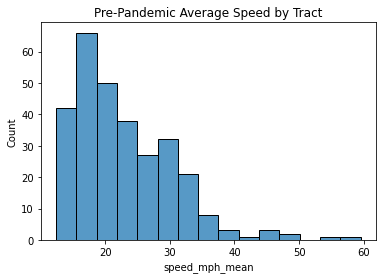

In [33]:
sns.histplot(averages_pre_named, x="speed_mph_mean")
plt.title("Pre-Pandemic Average Speed by Tract");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [34]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
averages_post = speeds_to_tract[speeds_to_tract["day"].isin(list(np.arange(14, 32)))].groupby("DISPLAY_NAME").agg("mean")["speed_mph_mean"]
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = speeds_to_tract[speeds_to_tract["day"].isin(list(np.arange(14, 32)))].groupby("DISPLAY_NAME").agg("mean")
averages_post_named

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,index_right,MOVEMENT_ID
DISPLAY_NAME,,,,,,,,,,,
"0 16th Avenue, Hayward Park, San Mateo",3.635955e+08,3.606957e+08,16.000000,25.844333,3.635955e+08,37.547553,-122.321966,3128.000000,-10194.000000,2453.0,2454.0
"0 Avoca Alley, West of Twin Peaks, San Francisco",4.882036e+08,5.966976e+08,18.786667,25.985005,4.882036e+08,37.735852,-122.442138,3144.066667,-10204.066667,1294.0,1295.0
"0 Bass Court, Bayview, San Francisco",1.182196e+09,1.614408e+09,15.947368,16.942162,1.182196e+09,37.731106,-122.383243,3144.000000,-10199.000000,301.0,302.0
"0 Berkeley Way, Diamond Heights, San Francisco",1.479586e+09,1.436973e+09,19.000000,27.495961,1.479586e+09,37.742207,-122.445505,3144.722348,-10204.413093,80.0,81.0
"0 Bernard Street, Nob Hill, San Francisco",1.110441e+09,1.040054e+09,18.183099,15.428398,1.110441e+09,37.796452,-122.414417,3149.000000,-10201.934272,865.0,866.0
...,...,...,...,...,...,...,...,...,...,...,...
"Old Guadalupe Trail, Daly City",1.160497e+09,1.517926e+09,18.023810,34.474071,1.160497e+09,37.701446,-122.425012,3141.166667,-10202.404762,2501.0,2502.0
"Old Sled Trail, Bolinas",1.141049e+09,9.459291e+08,17.762821,46.454665,1.141049e+09,37.839726,-122.485441,3152.801282,-10207.538462,949.0,950.0
"Petrolite Street, Richmond",4.823304e+08,4.835701e+08,18.381579,62.991894,4.823304e+08,37.927930,-122.378929,3160.000000,-10198.723684,1652.0,1653.0


In [35]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

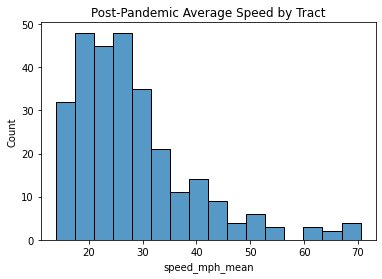

In [36]:
sns.histplot(averages_post_named, x="speed_mph_mean")
plt.title("Post-Pandemic Average Speed by Tract");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

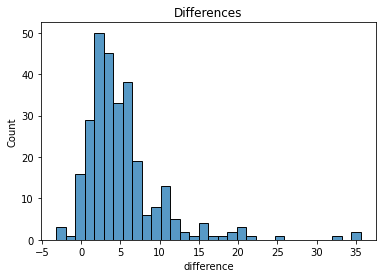

In [37]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
merged_pre_post = averages_post_named.reset_index().merge(averages_pre_named.reset_index(), 
                                                          how="inner", left_on="DISPLAY_NAME", 
                                                          right_on="DISPLAY_NAME")
merged_pre_post_cleaned = merged_pre_post[["speed_mph_mean_x", "speed_mph_mean_y", "MOVEMENT_ID_x"]].rename(columns = {"MOVEMENT_ID_x": "MOVEMENT_ID"})
merged_pre_post_cleaned["difference"] = merged_pre_post_cleaned["speed_mph_mean_x"] - merged_pre_post_cleaned["speed_mph_mean_y"]
merged_pre_post_cleaned.reindex(["MOVEMENT_ID"])
differences = merged_pre_post_cleaned["difference"]
# plot the differences
sns.histplot(merged_pre_post_cleaned, x="difference")
plt.title("Differences");

In [38]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

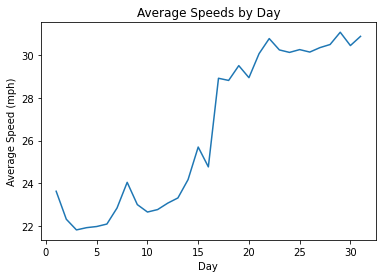

In [39]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby("day").agg("mean")["speed_mph_mean"]

plt.plot(speeds_daily)
plt.title("Average Speeds by Day")
plt.xlabel("Day")
plt.ylabel("Average Speed (mph)");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

In general, the average speed increases pretty sharply from around day 14-17. However, it increases a little from day 14-15 before very sharply increasing around day 16-17. 

Day 14-16: The average speed increased from around 23 mph to 25 mph (9% increase). This may be due to the beginnings of the lockdown. On March 14, 2020, UC Berkeley and Sonoma County announced its first reported cases, while Contra Costa and San Mateo began banning large group gatherings. On March 15, Governor Newsom orders all bars, nightclubs, wineries, and pubs to close, while urging those over 65 to stay home.

Day 16-17: The average speed increased sharply from around 25 mph to 29 mph (16%). This may be due to the shelter-in-place orders being announced on March 16 and taking effect on March 17. Once nearly 7 million Bay Area residents are told to shelter-in-place and restrict activities, traffic would probably decrease sharply, as residents only leave their houses for essential activities. Average speeds probably rose sharply due to the significant decrease in traffic on the road.

As a result of these growing restrictions, traffic began to gradually decrease, leading to higher average speeds, overall. After day 20, the graph begins to settle (since after all, speed limits are still in place)._Type your answer here, replacing this text._

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [40]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

The post-lockdown, difference correlation coefficient (.79) is significantly higher (stronger) than the pre-lockdown, difference correlation coefficient (.46). That means that the linear relationship between post-lockdown speeds and the change in speed is much stronger than pre-lockdown speeds and the change in speed. Thus, the changes are more "set" by the post-lockdown speeds than the pre-, which can indicate that pre-lockdown speeds were more clustered. This is consistent with the histograms seen above, as the pre-lockdown average speeds were more skewed and had more density around the 0-20 mph range than post-lockdown.

In a real world sense, this also makes sense. Pre-lockdown, every street/highway had significantly more traffic. This would slow down your speed on a main street and perhaps make it closer to speeds you would see on a side road with stop signs. This would also significantly slow down your speed on highways. As such, traffic could make speeds a lot more uniform across streets/highways. However, post-lockdown, there was significantly less traffic, which would lead to more divergence in speed. For example, with no traffic on main streets, you could go significantly faster than a side road. On highways as well, with less traffic, speeds became much higher than pre-lockdown, when traffic limited average speed. As such, post-lockdown, there was a lot more variance in speed as compared to pre-lockdown. Thus, when calculating correlation coefficients between post-lockdown speeds and change in speed vs pre-lockdown speeds and change in speed, it makes sense that the post-lockdown correlation coefficient would be higher, as the change is more so dictated by the post-lockdown speed.

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [41]:
corr_pre_diff = np.corrcoef(merged_pre_post_cleaned["speed_mph_mean_y"], differences)[1][0]
corr_post_diff = np.corrcoef(averages_post, differences)[1][0]
corr_pre_diff, corr_post_diff

(0.4633006380580185, 0.7926799984780657)

In [42]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

1st pattern: The San Francisco area has the lowest traffic. Most parts of San Francisco are purple (less than 20 mph), and San Francisco has the deepest colors. SF's population is the densest in the Bay and usually has a lot of traffic, so it makes sense that average speeds are lowest in SF.

2nd pattern: The lowest speeds are seen around the bottom right area of the graph, in the light green area (around 53-56 mph). These average speeds are significantly higher than those in the surrounding areas. This may be due to the fact that the area consists of a park (with very few cars) and the 280 highway (which sees a lot of traffic at high speeds). As such, even though the vast majority of the area is a park/mountain range, the average speed in that census tract is above 50 mph._Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

Text(0.5, 1.0, 'Average Daily Speeds per Census Tract, Pre-Lockdown')

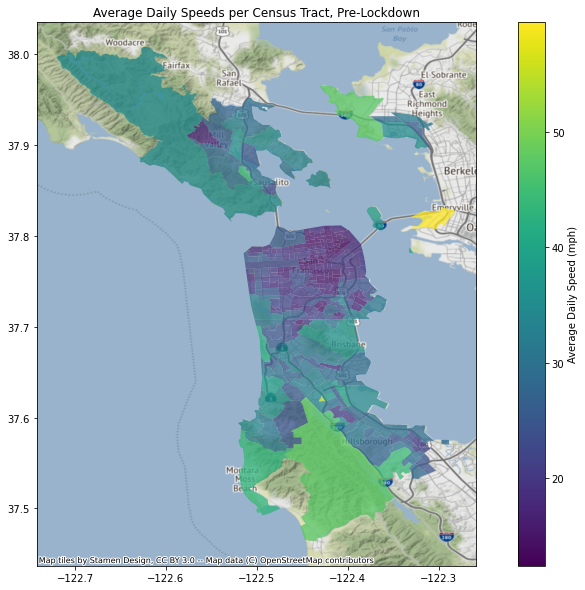

In [43]:
day_tract = speeds_to_tract.groupby("DISPLAY_NAME").agg('mean').reset_index().merge(tract_to_gps, on = "DISPLAY_NAME")
averages_pre_named_geo = averages_pre_named.merge(day_tract, on="DISPLAY_NAME")
bx = averages_pre_named_geo.plot(column="speed_mph_mean_x", figsize = (15, 10) , legend = True, 
                    legend_kwds={'label': "Average Daily Speed (mph)",'orientation': "vertical"},
                   alpha=.75);
cx.add_basemap(bx, crs=day_tract.crs.to_string())
plt.title("Average Daily Speeds per Census Tract, Pre-Lockdown")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

1st pattern: The Hillsborough/San Mateo area sees the largest change in average speed, increasing around 35 mph. This is probably due to the highway that runs through that census tract. As traffic decreases significantly on the highway, cars can go significantly faster.

2nd pattern: The SF area remains relatively unchanged, though there are some small changes in speed. This may be due to SF's roads being crowded (a lot of stoplights and stop signs). As such, even though traffic may have decreased, the average speed still cannot change much, as they are still limited by stoplights and stop signs.

3rd pattern: The Muir Woods/Golden Gate Recreational area sees a change of about 15 mph. This may be because people were not visiting these areas as often, leading to less traffic. The roads are also not as crowded together as SF's, but not as straightforward as 280 highway (it is more hilly, which restricts speed). As such, it makes sense that the traffic in this area increased more than SF's, but less than the 280 highway.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

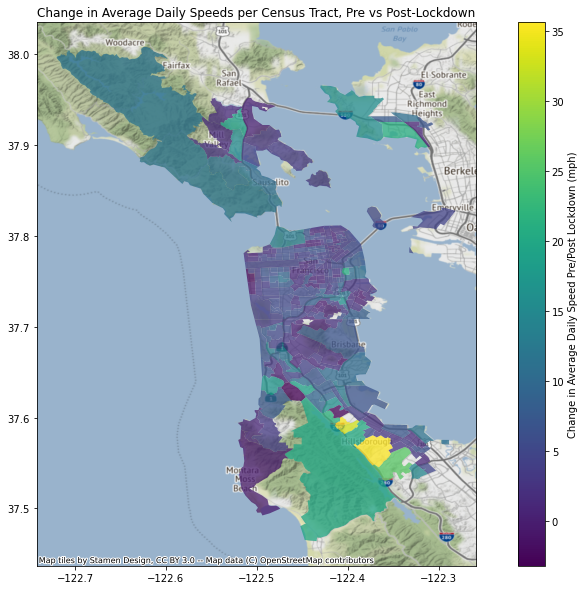

In [44]:
merged = averages_post_named.merge(averages_pre_named, on = "DISPLAY_NAME")
changes = merged.copy()
changes["differences"] = changes["speed_mph_mean_x"] - changes["speed_mph_mean_y"]
changes = day_tract.merge(changes, on = "DISPLAY_NAME")

bx2 = changes.plot(column = "differences", figsize = (15, 10) , legend = True,
                  legend_kwds={'label': "Change in Average Daily Speed Pre/Post Lockdown (mph)",'orientation': "vertical"},
                  alpha=.75);
cx.add_basemap(bx2, crs=changes.crs.to_string())
plt.title("Change in Average Daily Speeds per Census Tract, Pre vs Post-Lockdown");

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [45]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract
hayes_geo = times_to_tract[["Origin Movement ID", "Origin Display Name"]].merge(tract_to_gps, left_on = "Origin Movement ID", right_on = "MOVEMENT_ID") 
hayes_geo

,Origin Movement ID,Origin Display Name,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
1,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
2,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
3,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
4,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
10334,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
10335,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
10336,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."


In [46]:
#cleaning to avoid redundancy
hayes_times = times_to_tract.drop(columns = ["Origin Movement ID", "Origin Display Name"])

#adding a new column for the difference in the upper and lower ranges
hayes_times["Difference in Bounds"] = hayes_times["Range - Upper Bound Travel Time (Seconds)"] - hayes_times["Range - Lower Bound Travel Time (Seconds)"]

#creating Dataframes for 3 categories based on days: pre, post_immediate_hayes, and post lockdown
pre_hayes = hayes_times[times_to_tract["day"] <= 13].groupby("Destination Movement ID").agg('mean').drop(columns = ["day"])
post_immediate_hayes = hayes_times.set_index("day").loc[14:16, :].groupby("Destination Movement ID").agg('mean')
post_hayes = hayes_times[times_to_tract["day"] >= 17].groupby("Destination Movement ID").agg('mean').drop(columns = ["day"])

#merging the three DataFrames based on "Destination Movement ID"
pre_post_immediate_post_hayes = pre_hayes.merge(post_immediate_hayes, on = "Destination Movement ID").merge(post_hayes, on = "Destination Movement ID").reset_index()
pre_post_immediate_post_hayes

,Destination Movement ID,Mean Travel Time (Seconds)_x,Range - Lower Bound Travel Time (Seconds)_x,Range - Upper Bound Travel Time (Seconds)_x,Difference in Bounds_x,Mean Travel Time (Seconds)_y,Range - Lower Bound Travel Time (Seconds)_y,Range - Upper Bound Travel Time (Seconds)_y,Difference in Bounds_y,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds
0,9,343.615385,225.076923,523.461538,298.384615,279.333333,190.000000,409.666667,219.666667,248.666667,169.866667,365.000000,195.133333
1,20,319.461538,199.769231,509.384615,309.615385,260.000000,171.666667,392.666667,221.000000,222.666667,153.000000,324.933333,171.933333
2,21,622.153846,463.692308,835.307692,371.615385,531.000000,417.666667,673.666667,256.000000,457.500000,397.500000,526.583333,129.083333
3,44,864.846154,622.615385,1201.923077,579.307692,731.333333,535.666667,998.666667,463.000000,613.666667,448.444444,958.555556,510.111111
4,46,1012.923077,743.153846,1385.615385,642.461538,988.666667,744.666667,1320.666667,576.000000,854.000000,681.133333,1112.133333,431.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2660,1146.692308,954.230769,1378.307692,424.076923,1090.333333,740.666667,1758.666667,1018.000000,941.625000,835.000000,1074.625000,239.625000
332,2673,454.846154,320.461538,644.384615,323.923077,391.000000,284.666667,536.333333,251.666667,332.733333,254.000000,434.866667,180.866667
333,2694,349.923077,222.538462,549.384615,326.846154,299.000000,189.666667,470.666667,281.000000,245.333333,171.400000,351.800000,180.400000
334,2695,1134.615385,889.230769,1451.000000,561.769231,1107.000000,883.666667,1387.333333,503.666667,917.000000,778.000000,1080.000000,302.000000


In [47]:
pre_post_immediate_post_hayes_geo = tract_to_gps.merge(pre_post_immediate_post_hayes, left_on = "MOVEMENT_ID", right_on = "Destination Movement ID").drop(columns=["MOVEMENT_ID"])
pre_post_immediate_post_hayes_geo["Difference in Mean Travel Time (Seconds) Pre vs Post_Immediate"] = pre_post_immediate_post_hayes_geo["Mean Travel Time (Seconds)_x"] - pre_post_immediate_post_hayes_geo["Mean Travel Time (Seconds)_y"]
pre_post_immediate_post_hayes_geo["Difference in Mean Travel Time (Seconds) Pre vs Post"] = pre_post_immediate_post_hayes_geo["Mean Travel Time (Seconds)_x"] - pre_post_immediate_post_hayes_geo["Mean Travel Time (Seconds)"]
pre_post_immediate_post_hayes_geo

,DISPLAY_NAME,geometry,Destination Movement ID,Mean Travel Time (Seconds)_x,Range - Lower Bound Travel Time (Seconds)_x,Range - Upper Bound Travel Time (Seconds)_x,Difference in Bounds_x,Mean Travel Time (Seconds)_y,Range - Lower Bound Travel Time (Seconds)_y,Range - Upper Bound Travel Time (Seconds)_y,Difference in Bounds_y,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds,Difference in Mean Travel Time (Seconds) Pre vs Post_Immediate,Difference in Mean Travel Time (Seconds) Pre vs Post
0,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",9,343.615385,225.076923,523.461538,298.384615,279.333333,190.000000,409.666667,219.666667,248.666667,169.866667,365.000000,195.133333,64.282051,94.948718
1,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",20,319.461538,199.769231,509.384615,309.615385,260.000000,171.666667,392.666667,221.000000,222.666667,153.000000,324.933333,171.933333,59.461538,96.794872
2,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",21,622.153846,463.692308,835.307692,371.615385,531.000000,417.666667,673.666667,256.000000,457.500000,397.500000,526.583333,129.083333,91.153846,164.653846
3,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",44,864.846154,622.615385,1201.923077,579.307692,731.333333,535.666667,998.666667,463.000000,613.666667,448.444444,958.555556,510.111111,133.512821,251.179487
4,"500 Chester Street, West Oakland, Oakland","MULTIPOLYGON (((-122.30403 37.80739, -122.3023...",46,1012.923077,743.153846,1385.615385,642.461538,988.666667,744.666667,1320.666667,576.000000,854.000000,681.133333,1112.133333,431.000000,24.256410,158.923077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,"0 Burgess Court, Sausalito","MULTIPOLYGON (((-122.52032 37.87046, -122.5193...",2660,1146.692308,954.230769,1378.307692,424.076923,1090.333333,740.666667,1758.666667,1018.000000,941.625000,835.000000,1074.625000,239.625000,56.358974,205.067308
332,"100 Rutledge Street, Bernal Heights, San Franc...","MULTIPOLYGON (((-122.41066 37.74242, -122.4093...",2673,454.846154,320.461538,644.384615,323.923077,391.000000,284.666667,536.333333,251.666667,332.733333,254.000000,434.866667,180.866667,63.846154,122.112821
333,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",2694,349.923077,222.538462,549.384615,326.846154,299.000000,189.666667,470.666667,281.000000,245.333333,171.400000,351.800000,180.400000,50.923077,104.589744
334,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858...",2695,1134.615385,889.230769,1451.000000,561.769231,1107.000000,883.666667,1387.333333,503.666667,917.000000,778.000000,1080.000000,302.000000,27.615385,217.615385


In [48]:
golden_gate = pre_post_immediate_post_hayes_geo.loc[pre_post_immediate_post_hayes_geo['DISPLAY_NAME'].str.contains("Golden Gate Park", case=False)]
golden_gate

,DISPLAY_NAME,geometry,Destination Movement ID,Mean Travel Time (Seconds)_x,Range - Lower Bound Travel Time (Seconds)_x,Range - Upper Bound Travel Time (Seconds)_x,Difference in Bounds_x,Mean Travel Time (Seconds)_y,Range - Lower Bound Travel Time (Seconds)_y,Range - Upper Bound Travel Time (Seconds)_y,Difference in Bounds_y,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds,Difference in Mean Travel Time (Seconds) Pre vs Post_Immediate,Difference in Mean Travel Time (Seconds) Pre vs Post
176,"200 John F Kennedy Drive, Golden Gate Park, Sa...","MULTIPOLYGON (((-122.51307 37.77078, -122.5111...",1300,400.076923,253.076923,630.692308,377.615385,350.666667,223.666667,548.0,324.333333,294.6,200.066667,432.733333,232.666667,49.410256,105.476923


In [49]:
#seeing how variation in the difference in the upper and lower bounds changes over days
pre_bounds_var = pre_post_immediate_post_hayes_geo["Difference in Bounds_x"].std()
post_immediate_bounds_var = pre_post_immediate_post_hayes_geo["Difference in Bounds_y"].std()
post_bounds_var = pre_post_immediate_post_hayes_geo["Difference in Bounds"].std()
pre_bounds_var, post_immediate_bounds_var, post_bounds_var

(188.01800699117786, 168.59133959645868, 361.4937158603355)

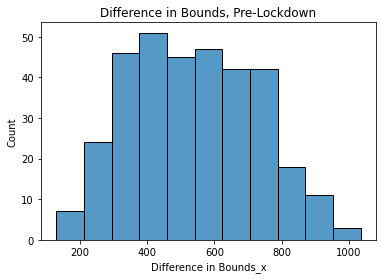

In [50]:
#plotting a histogram to visualize variation pre-lockdown
sns.histplot(pre_post_immediate_post_hayes_geo, x = "Difference in Bounds_x")
plt.title("Difference in Bounds, Pre-Lockdown");

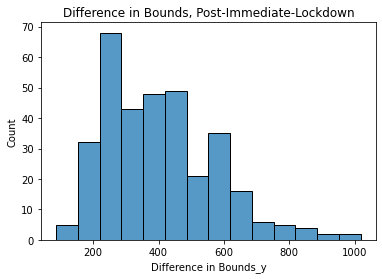

In [51]:
#plotting a histogram to visualize variation immediately post lockdown
sns.histplot(pre_post_immediate_post_hayes_geo, x = "Difference in Bounds_y")
plt.title("Difference in Bounds, Post-Immediate-Lockdown");

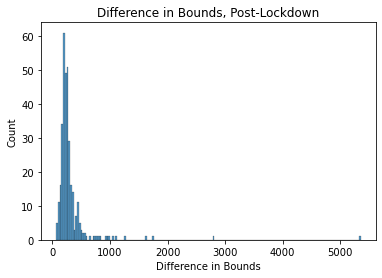

In [52]:
#plotting a histogram to visualize variation post-lockdown
sns.histplot(pre_post_immediate_post_hayes_geo, x = "Difference in Bounds")
plt.title("Difference in Bounds, Post-Lockdown");

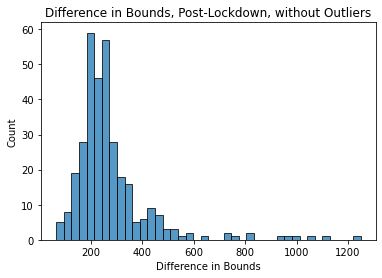

In [53]:
#plotting a histogram to visualize variation post-lockdown after removing outliers
post_bounds_diff = pre_post_immediate_post_hayes_geo["Difference in Bounds"]
benchmark = np.percentile(post_bounds_diff, 50) + 1.5 * (np.percentile(post_bounds_diff, 75) - np.percentile(post_bounds_diff, 25))
sns.histplot(pre_post_immediate_post_hayes_geo[post_bounds_diff <= 1500], x = "Difference in Bounds")
plt.title("Difference in Bounds, Post-Lockdown, without Outliers");

In [54]:
#seeing how variation in mean changes over days
pre_mean_var = pre_post_immediate_post_hayes_geo["Mean Travel Time (Seconds)_x"].std()
post_immediate_mean_var = pre_post_immediate_post_hayes_geo["Mean Travel Time (Seconds)_y"].std()
post_mean_var = pre_post_immediate_post_hayes_geo["Mean Travel Time (Seconds)"].std()
pre_mean_var, post_immediate_mean_var, post_mean_var

(528.8050007869201, 472.1469988649982, 468.23635816874673)

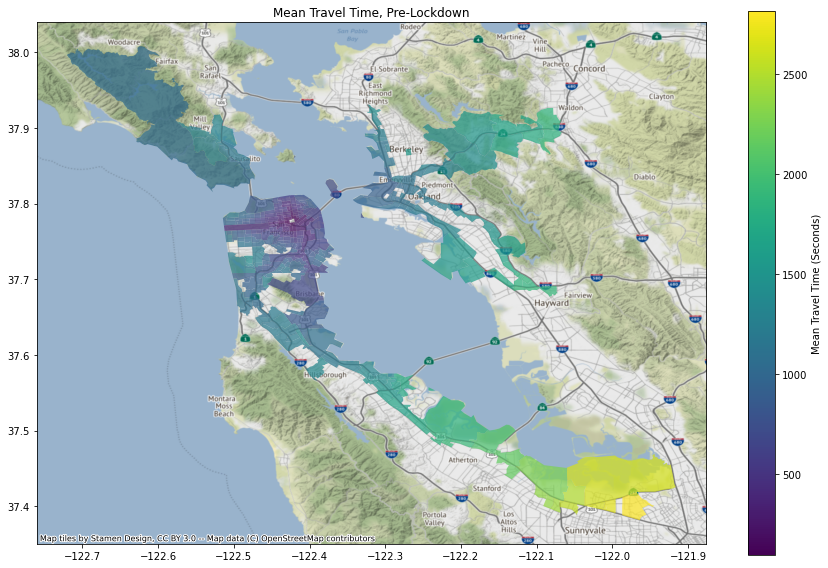

In [55]:
bx3 = pre_post_immediate_post_hayes_geo.plot(column="Mean Travel Time (Seconds)_x", figsize = (15, 10) , legend = True, 
                    legend_kwds={'label': "Mean Travel Time (Seconds)",'orientation': "vertical"}, alpha = 0.7);
cx.add_basemap(bx3, crs=pre_post_immediate_post_hayes_geo.crs.to_string())
plt.title("Mean Travel Time, Pre-Lockdown");

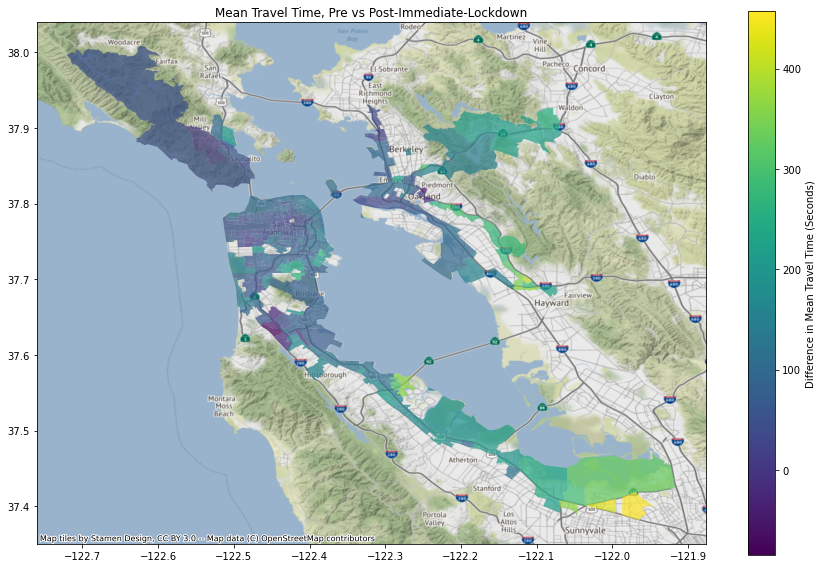

In [56]:
bx4 = pre_post_immediate_post_hayes_geo.plot(column="Difference in Mean Travel Time (Seconds) Pre vs Post_Immediate", figsize = (15, 10) , legend = True, 
                    legend_kwds={'label': "Difference in Mean Travel Time (Seconds)",'orientation': "vertical"}, alpha = 0.7);
cx.add_basemap(bx4, crs=pre_post_immediate_post_hayes_geo.crs.to_string())
plt.title("Mean Travel Time, Pre vs Post-Immediate-Lockdown");

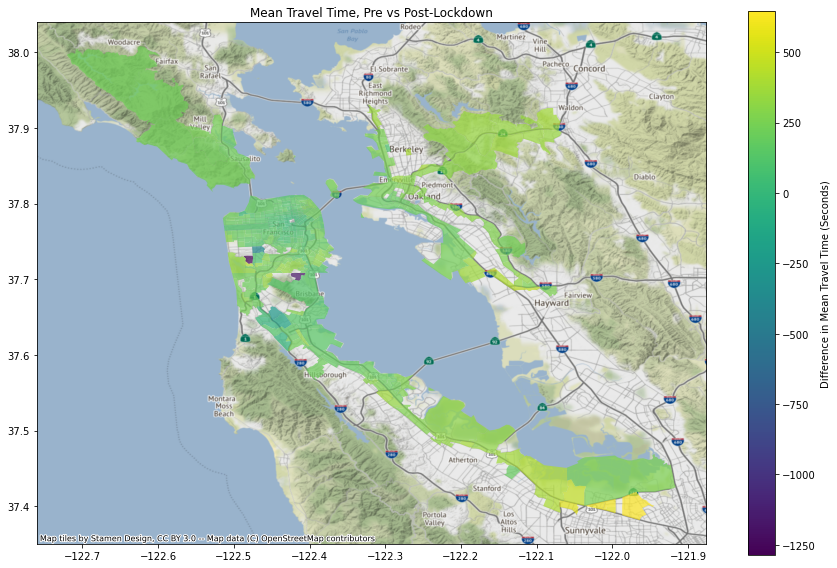

In [57]:
bx5 = pre_post_immediate_post_hayes_geo.plot(column="Difference in Mean Travel Time (Seconds) Pre vs Post", figsize = (15, 10) , legend = True, 
                    legend_kwds={'label': "Difference in Mean Travel Time (Seconds)",'orientation': "vertical"}, alpha = 0.7);
cx.add_basemap(bx5, crs=pre_post_immediate_post_hayes_geo.crs.to_string())
plt.title("Mean Travel Time, Pre vs Post-Lockdown");

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [58]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    return df.pivot_table(index = "MOVEMENT_ID", columns = "day", values = "speed_mph_mean")
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [59]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [60]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
        
    """
    
    days = len(df.columns)
    split = defaultdict(list)
    arrays = df.to_numpy()

    
    for day in np.arange(days - T):
        
        if day >= days - T - n_val:
            cat = 'val'
        else:
            cat = 'train'
            
        split[f'X_{cat}'].append(arrays[:, day:day+T])
        split[f'y_{cat}'].append(arrays[:, day+T])
        
    for key in split:
        split[key] = np.concatenate(split[key], axis = 0)
        
    return split['X_train'], split['y_train'], split['X_val'], split['y_val']

def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    else:
        all_true = ~np.logical_or(np.isnan(X).any(axis = 1), np.isnan(y))
    return X[all_true], y[all_true]
    
answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [61]:
grader.check("q4ai2")

q4ai2 results:
    q4ai2 - 1 result:
        Trying:
            answer[0].shape == (5900, 10)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai2 0
        Failed example:
            answer[0].shape == (5900, 10)
        Expected:
            True
        Got:
            False

    q4ai2 - 2 result:
        Trying:
            answer[1].shape == (5900,)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai2 1
        Failed example:
            answer[1].shape == (5900,)
        Expected:
            True
        Got:
            False

    q4ai2 - 3 result:
        Trying:
            answer[2].shape == (295, 10)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai2 2
        Failed example:
            answer[2].shape == (295, 10)
        Expected:
            True
        Got:
            False

    q4ai2 - 4 result:
        Trying:
            answer[3].shape == (295,)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai2 3
        Failed example:
            answer[3].shape == (295,)
        Expected:
            True
        Got:
            False

    q4ai2 - 5 result:
        Trying:
            answer2[0].shape == (4528, 10)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai2 4
        Failed example:
            answer2[0].shape == (4528, 10)
        Expected:
            True
        Got:
            False

    q4ai2 - 6 result:
        Trying:
            answer2[1].shape == (4528,)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai2 5
        Failed example:
            answer2[1].shape == (4528,)
        Expected:
            True
        Got:
            False

In [62]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    arrays = time_series_to_numpy(time_series, T, n_val)
    X_train, y_train = remove_nans(arrays[0], arrays[1])
    X_val, y_val = remove_nans(arrays[2], arrays[3])
    return X_train, y_train, X_val, y_val
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [63]:
grader.check("q4ai3")

q4ai3 results:
    q4ai3 - 1 result:
        Trying:
            X_train.shape = (1986, 5)
        Expecting nothing
        **********************************************************************
        Line 1, in q4ai3 0
        Failed example:
            X_train.shape = (1986, 5)
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4ai3 0[0]>", line 1, in <module>
                X_train.shape = (1986, 5)
            ValueError: cannot reshape array of size 8525 into shape (1986,5)

    q4ai3 - 2 result:
        Trying:
            y_train.shape == (1986,)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai3 1
        Failed example:
            y_train.shape == (1986,)
        Expected:
            True
        Got:
            False

    q4ai3 - 3 result:
        Trying:
            X_val.shape == (281, 5)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai3 2
        Failed example:
            X_val.shape == (281, 5)
        Expected:
            True
        Got:
            False

    q4ai3 - 4 result:
        Trying:
            y_val.shape == (281,)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai3 3
        Failed example:
            y_val.shape == (281,)
        Expected:
            True
        Got:
            False

In [64]:
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [65]:
time_series_pre

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,13.739901,14.391436,13.955833
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,14.637109,14.282602,14.437358
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,13.790100,14.573349,15.177251
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,23.756560,24.989269,23.176275
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,15.773117,16.091415,16.208158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,NaN,22.107000,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,16.891788,17.008323,17.559142
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,23.870537,20.215396,20.343131


In [66]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

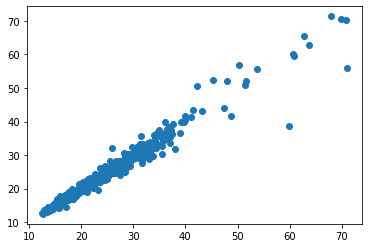

In [67]:
lm = LinearRegression()
reg = lm.fit(X_train, y_train) # set to trained linear model

score = reg.score(X_val, y_val) # report r^2 score

# create the scatter plot below
Y_pred = reg.predict(X_val)
plt.scatter(Y_pred, y_val);

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [68]:
score

0.9639232922122069

In [69]:
grader.check("q4aii2")

q4aii2 results:
    q4aii2 - 1 result:
        Trying:
            np.isclose(score, 0.9695195948737512)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4aii2 0
        Failed example:
            np.isclose(score, 0.9695195948737512)
        Expected:
            True
        Got:
            False

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [70]:
time_series_x_pre = time_series_to_dataset(time_series[np.arange(9, 15)], 5, 0)[0] # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post = time_series_to_dataset(time_series[np.arange(9, 15)], 5, 0)[1] # get 'time series' dataframe for 14th

score_pre_14th = reg.score(time_series_x_pre, time_series_y_post)
score_pre_14th

0.9337122097376677

In [71]:
grader.check("q4bi1")

q4bi1 results:
    q4bi1 - 1 result:
        Trying:
            np.isclose(score_pre_14th, 0.9331284677999099)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4bi1 0
        Failed example:
            np.isclose(score_pre_14th, 0.9331284677999099)
        Expected:
            True
        Got:
            False

In [72]:
time_series_x_pre

array([[14.84532001, 14.71153361, 13.73990125, 14.3914358 , 13.95583259],
       [16.17810543, 15.29549397, 14.63710904, 14.28260209, 14.43735825],
       [15.61621536, 14.85047114, 13.79010039, 14.57334878, 15.17725078],
       ...,
       [20.4970768 , 20.40108451, 23.8705369 , 20.2153963 , 20.34313065],
       [32.17986695, 32.9518555 , 31.57452517, 32.17295775, 31.33436375],
       [25.51240295, 24.88606305, 23.90259874, 25.26272056, 24.45002487]])

In [73]:
time_series_y_post

array([15.87805614, 16.09538544, 15.17225238, 25.00645192, 15.1288    ,
       16.7048158 , 18.77729159, 23.98522813, 25.03852101, 30.76832456,
       17.77197562, 18.11368942, 28.02313988, 20.82763148, 17.42694207,
       18.22003466, 28.26654435, 29.32978935, 20.73002755, 17.33082953,
       25.213125  , 35.62818654, 60.35547222, 15.25889038, 18.61711905,
       30.73814813, 31.88187256, 31.3947788 , 31.81918147, 25.88585606,
       18.56674462, 18.16756015, 17.15433443, 16.00452038, 60.76129862,
       30.60442575, 18.3730735 , 18.81192524, 17.6888209 , 23.05320108,
       17.52912136, 16.30571395, 26.5748976 , 35.29862818, 38.50747421,
       19.46483041, 15.82690418, 17.80623106, 15.38788273, 14.12497315,
       16.23102798, 15.26397466, 16.07743469, 16.74570089, 22.65961155,
       28.44381007, 13.91921591, 30.9269172 , 20.37785778, 21.22272118,
       20.00507443, 23.90197941, 23.69164573, 19.11505735, 29.0305431 ,
       27.62038497, 31.07392876, 25.43576819, 35.83537867, 35.40

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

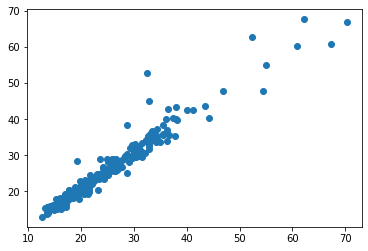

In [74]:
post_pred = reg.predict(time_series_x_pre)
plt.scatter(post_pred, time_series_y_post);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



2) The worst performance is on March 17th; there is a significant dip in the line plot.

3) The model is a Linear Regression model that is trained on pre-lockdown data and predicts average speeds by tract based on the previous 5 days' average speeds. As such, the model won't do well if traffic suddenly changes significantly from the 5 previous days. Traffic patterns began changing on the 15th when the governor announced that all nightlife would be closing. Traffic then lessened dramatically on the 17th because that was when shelter-in-place orders took effect. Due to the traffic on the 15th and 17th being very different from the previous 5 days, the model's performance began to worsen on the 15th, then dramatically dipped on the 17th.

4) It is. If we go back and look at our line plot for Average Speeds by Day, we see that there is a spike on the 9th.

5) The model recovered because the model predicts average speeds on the average speeds from the previous 5 days. Once the lockdown began to take effect (from the 15th - 17th), our model began taking in post-lockdown data as inputs. As such, our model was able to recover and more accurately predict post-lockdown traffic.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

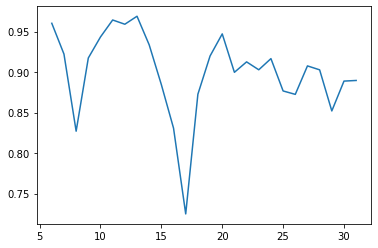

In [75]:
scores = []
for day in np.arange(1, 27): 
    x_train = time_series_to_dataset(time_series[np.arange(day, day + 6)], 5, 0)[0] # get 'time series' dataframe for days 8, 10, 11, 12, 13
    y_pred = time_series_to_dataset(time_series[np.arange(day, day + 6)], 5, 0)[1]
    scores.append(reg.score(x_train, y_pred))
plt.plot(np.arange(6, 32), scores);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

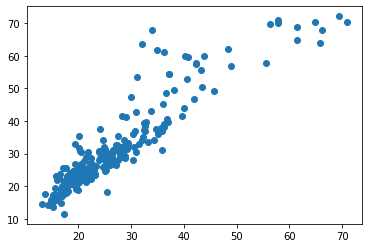

In [76]:
time_series_x_pre = time_series_to_dataset(time_series[np.arange(12, 18)], 5, 0)[0] # get 'time series' dataframe for days 8, 10, 11, 12, 13
Y_actual17 = time_series_to_dataset(time_series[np.arange(12, 18)], 5, 0)[1]
Y_pred17 = reg.predict(time_series_x_pre)
plt.scatter(Y_pred17, Y_actual17);

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

4) Our delta model predicts average speeds by tract based on deltas (difference between actual sample value and a running average) over the past 5 days. By the 17th, traffic patterns had already begun changing a few days ago (as reflected in our Average Speeds by Day lineplot), and our deltas had already reflected that change. As such, on the 17th, if we take the 16th's average (which already reflects post-lockdown traffic changes), and then change that based on the specific census tract's delta, we should get a prediction that is more accurate than simply predicting based off the past 5 days' averages. Essentially, our delta model "learns" faster than the original one. However, the delta model is a lot more dependent on the previous day's average speed, since that's what we just take as our predicted day's average as well. This is reflected in the r^2 score for day 14th (when the lockdown began).

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [77]:
(time_series - speeds_daily)[np.arange(13, 19)]

day,13,14,15,16,17,18
MOVEMENT_ID,,,,,,
9,-9.364599,-8.299408,-9.338214,-10.389922,-13.734386,-13.641223
20,-8.883074,-8.082079,-9.054164,-8.984059,-11.549345,-11.435672
21,-8.143181,-9.005212,-9.414061,-8.510261,NaN,NaN
44,-0.144157,0.828988,-0.306110,0.422019,-2.026986,-1.744957
78,-7.112274,-9.048664,-9.645762,-7.638639,-14.254335,-9.018352
...,...,...,...,...,...,...
2691,NaN,-6.260464,NaN,NaN,NaN,NaN
2694,-5.761289,-6.462535,-5.951842,-5.446096,-6.140698,-5.523367
2695,-2.977301,-3.856047,-2.568321,-1.331630,-3.223668,-1.797052


In [78]:
time_series_delta = (time_series - speeds_daily)[np.arange(1, 14)] # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,-7.436210,-7.929735,-7.957726,-7.706332,-7.673488,-8.288859,-7.342673,-7.838718,-8.163539,-7.950124,-9.037052,-8.687048,-9.364599
20,-6.215082,-6.863900,-6.363125,-6.511982,-6.693731,-6.873540,-5.762984,-5.960594,-6.830754,-7.366163,-8.139844,-8.795882,-8.883074
21,-8.491956,-9.147858,-8.044932,-7.879632,-7.907553,-8.464493,-8.893040,-9.407162,-7.392644,-7.811186,-8.986853,-8.505135,-8.143181
44,1.446417,1.167730,0.901289,0.342397,-0.110985,0.981564,0.024509,1.604391,0.492527,0.078211,0.979607,1.910786,-0.144157
78,-7.458664,-5.569360,-5.787301,-5.813345,-6.320619,-6.303126,-7.548693,-4.765377,-6.755502,-6.530367,-7.003837,-6.987069,-7.112274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,-3.385687,-4.313850,0.621691,NaN,-3.970859,NaN,NaN,-0.971484,NaN
2694,-5.823366,-5.598968,-5.295639,-5.485229,-5.482634,-5.448377,-5.423980,-5.992169,-5.698587,-5.662927,-5.885166,-6.070161,-5.761289
2695,-3.527067,-2.096006,-1.977287,-1.785869,0.371917,-2.850371,-3.627592,-4.578175,-2.511783,-2.260573,1.093583,-2.863087,-2.977301


In [79]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [80]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)
reg_delta = lm.fit(X_delta_train, y_delta_train)
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [81]:
grader.check("q4ci3")

q4ci3 results:
    q4ci3 - 1 result:
        Trying:
            np.isclose(res_4ci3, 0.9696154476287225)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci3 0
        Failed example:
            np.isclose(res_4ci3, 0.9696154476287225)
        Expected:
            True
        Got:
            False

In [82]:
x_train_delta_17 = time_series_to_dataset(time_series.iloc[11:16], 5, 0)[0] # get 'time series' dataframe for days 8, 10, 11, 12, 13
y_pred_delta_17 = time_series_to_dataset(time_series.iloc[11:16], 5, 0)[1]
res_4ci4 = reg_delta.score(x_train_delta_17, y_pred_delta_17)
res_4ci4

0.8300573806020428

In [83]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8611062043086541)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8611062043086541)
        Expected:
            True
        Got:
            False

In [84]:
res_4ci5 = ...

In [85]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11360677564014343)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11360677564014343)
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4ci5 0[0]>", line 1, in <module>
                np.isclose(res_4ci5, 0.11360677564014343)
              File "<__array_function__ internals>", line 5, in isclose
              File "/opt/conda/lib/python3.9/site-packages/numpy/core/numeric.py", line 2355, in isclose
                xfin = isfinite(x)
            TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [86]:
time_series_x_post = time_series_to_dataset(time_series.iloc[:, 13:], 5, 0)[0]
time_series_y_post = time_series_to_dataset(time_series.iloc[:, 13:], 5, 0)[1]
reg = lm.fit(X_train, y_train)
score_og_post = reg.score(time_series_x_post, time_series_y_post)
score_og_post

0.9014738674628208

In [87]:
grader.check("q4cii")

q4cii results:
    q4cii - 1 result:
        Trying:
            np.isclose(score_og_post, 0.9018308473872704)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4cii 0
        Failed example:
            np.isclose(score_og_post, 0.9018308473872704)
        Expected:
            True
        Got:
            False

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [88]:
x_post_train, y_post_train, x_post_val, y_post_val = time_series_to_dataset(time_series.iloc[:, 13:], 5, 2)
reg = lm.fit(x_post_train, y_post_train)
score_post = reg.score(x_post_val, y_post_val)
score_post

0.8993687576351703

In [89]:
grader.check("q4ciii")

q4ciii results:
    q4ciii - 1 result:
        Trying:
            np.isclose(score_post, 0.896903094167119)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ciii 0
        Failed example:
            np.isclose(score_post, 0.896903094167119)
        Expected:
            True
        Got:
            False

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [90]:
x_post_train, y_post_train, x_post_val, y_post_val = time_series_to_dataset(time_series, 5, 5)
reg = lm.fit(x_post_train, y_post_train)
res_4civ = reg.score(x_post_val, y_post_val)
res_4civ

0.8843433608623491

In [91]:
grader.check("q4civ")

q4civ results:
    q4civ - 1 result:
        Trying:
            np.isclose(res_4civ, 0.8804288384478637)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4civ 0
        Failed example:
            np.isclose(res_4civ, 0.8804288384478637)
        Expected:
            True
        Got:
            False

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [92]:
# Load census tract names dataset into dataframe (https://data.sfgov.org/Geographic-Locations-and-Boundaries/Census-2010-Tracts-for-San-Francisco/rarb-5ahf)
census_tracts = pd.read_csv("data/Census_2010_Tracts.csv")
census_tracts = census_tracts.rename(columns={"NAMELSAD10":"name", "the_geom":"geometry"}).drop(columns=['NAME10', 'STATEFP10', 'TRACTCE10', 'COUNTYFP10', 'GEOID10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10'])
#census_tracts_gpd = gpd.GeoDataFrame(census_tracts, geometry=gpd.points_from_xy(census_tracts['INTPTLON10'], census_tracts['INTPTLAT10']))
census_tracts

,geometry,name,INTPTLAT10,INTPTLON10
0,"MULTIPOLYGON (((-122.446471 37.775802, -122.44...",Census Tract 165,37.774196,-122.447788
1,MULTIPOLYGON (((-122.44033999999999 37.7765799...,Census Tract 164,37.775100,-122.436973
2,MULTIPOLYGON (((-122.429152 37.778006999999995...,Census Tract 163,37.776046,-122.429551
3,"MULTIPOLYGON (((-122.428909 37.778039, -122.42...",Census Tract 161,37.779983,-122.428663
4,"MULTIPOLYGON (((-122.420425 37.780583, -122.42...",Census Tract 160,37.782336,-122.422484
...,...,...,...,...
192,"MULTIPOLYGON (((-122.40715900000001 37.779739,...",Census Tract 176.01,37.779434,-122.410724
193,MULTIPOLYGON (((-122.44257499999999 37.7659279...,Census Tract 170,37.764887,-122.439498
194,"MULTIPOLYGON (((-122.42694799999998 37.769175,...",Census Tract 169,37.767096,-122.432478
195,"MULTIPOLYGON (((-122.439301 37.768166, -122.44...",Census Tract 167,37.770348,-122.437736


In [93]:
# Load 2020 income per census_tracts dataset into dataframe (https://censusreporter.org/data/table/?table=B19013&geo_ids=140|05000US06075)
income_per_tract = pd.read_csv("data/Median_Household_Income.csv")
income_per_tract = income_per_tract.rename(columns={"B19013001":"median income"}).drop(columns=['B19013001, Error', 'geoid'])
deleted_SF = income_per_tract['name'].str.replace(', San Francisco, CA','')
income_per_tract['name'] = deleted_SF
income_per_tract

,name,median income
0,Census Tract 101,62414.0
1,Census Tract 102,151453.0
2,Census Tract 103,150972.0
3,Census Tract 104,130732.0
4,Census Tract 105,135300.0
...,...,...
192,Census Tract 9804.01,NaN
193,Census Tract 9805.01,12340.0
194,Census Tract 9806,66042.0
195,Census Tract 9809,NaN


In [94]:
# Get median income and geometry of each census tract by merging on census_tracts 'name'
tract_income_geo = income_per_tract.merge(census_tracts, how='left', on='name')
tract_income_geo_gpd = gpd.GeoDataFrame(tract_income_geo, geometry = gpd.points_from_xy(tract_income_geo.INTPTLON10, tract_income_geo.INTPTLAT10))
tract_income_geo_gpd

,name,median income,geometry,INTPTLAT10,INTPTLON10
0,Census Tract 101,62414.0,POINT (-122.40858 37.80842),37.808420,-122.408579
1,Census Tract 102,151453.0,POINT (-122.42293 37.80586),37.805861,-122.422925
2,Census Tract 103,150972.0,POINT (-122.41568 37.80162),37.801620,-122.415681
3,Census Tract 104,130732.0,POINT (-122.40756 37.80227),37.802273,-122.407558
4,Census Tract 105,135300.0,POINT (-122.39906 37.80268),37.802684,-122.399059
...,...,...,...,...,...
192,Census Tract 9804.01,NaN,POINT (-123.03223 37.72724),37.727239,-123.032229
193,Census Tract 9805.01,12340.0,POINT (-122.41916 37.71630),37.716296,-122.419155
194,Census Tract 9806,66042.0,POINT (-122.36854 37.72317),37.723166,-122.368542
195,Census Tract 9809,NaN,POINT (-122.38948 37.74629),37.746286,-122.389477


In [95]:
# Mean travel time and income

In [96]:
post_hayes_times = hayes_times[times_to_tract["day"] >= 14].groupby("Destination Movement ID").agg('mean').reset_index()
post_hayes_times = tract_to_gps[["geometry", "MOVEMENT_ID"]].merge(post_hayes_times, left_on = "MOVEMENT_ID", right_on = "Destination Movement ID").drop(columns=["MOVEMENT_ID", "day"]).reset_index()
post_hayes_times

,index,geometry,Destination Movement ID,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds
0,0,"MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",9,253.777778,173.222222,372.444444,199.222222
1,1,"MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",20,228.888889,156.111111,336.222222,180.111111
2,2,"MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",21,472.200000,401.533333,556.000000,154.466667
3,3,"MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",44,643.083333,470.250000,968.583333,498.333333
4,4,"MULTIPOLYGON (((-122.30403 37.80739, -122.3023...",46,876.444444,691.722222,1146.888889,455.166667
...,...,...,...,...,...,...,...
444,444,"MULTIPOLYGON (((-122.41066 37.74242, -122.4093...",2673,342.444444,259.111111,451.777778,192.666667
445,445,"MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",2694,254.277778,174.444444,371.611111,197.166667
446,446,"MULTIPOLYGON (((-122.49505 37.74968, -122.4858...",2695,1059.500000,857.250000,1310.500000,453.250000
447,447,"MULTIPOLYGON (((-122.44834 37.64598, -122.4460...",2700,1293.428571,898.000000,1922.428571,1024.428571


In [97]:
# Spatial join tract_time and tract_income_geo
# Final data to build model on
post_hayes_times.crs = tract_income_geo_gpd.crs
tract_time_income = gpd.sjoin(post_hayes_times, tract_income_geo_gpd, how='inner').drop(columns=['INTPTLAT10', 'INTPTLON10', 'index_right', 'index'])
tract_time_income = tract_time_income.dropna()
tract_time_income.isnull().values.any()
tract_time_income

,geometry,Destination Movement ID,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds,name,median income
0,"MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",9,253.777778,173.222222,372.444444,199.222222,Census Tract 122.01,67569.0
1,"MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",20,228.888889,156.111111,336.222222,180.111111,Census Tract 120,51788.0
2,"MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",21,472.200000,401.533333,556.000000,154.466667,Census Tract 126.01,149485.0
3,"MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",44,643.083333,470.250000,968.583333,498.333333,Census Tract 233,60104.0
7,"MULTIPOLYGON (((-122.39270 37.72928, -122.3918...",78,755.222222,611.222222,934.666667,323.444444,Census Tract 232,81958.0
...,...,...,...,...,...,...,...,...
438,"MULTIPOLYGON (((-122.38502 37.72410, -122.3821...",2629,856.000000,697.000000,1050.000000,353.000000,Census Tract 9806,66042.0
440,"MULTIPOLYGON (((-122.39668 37.72027, -122.3932...",2643,651.000000,532.500000,796.700000,264.200000,Census Tract 234,51971.0
444,"MULTIPOLYGON (((-122.41066 37.74242, -122.4093...",2673,342.444444,259.111111,451.777778,192.666667,Census Tract 251,159375.0
445,"MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",2694,254.277778,174.444444,371.611111,197.166667,Census Tract 152,101475.0


In [98]:
tract_income_geo_gpd.crs = speeds_to_tract.crs
tract_income_geo_gpd

,name,median income,geometry,INTPTLAT10,INTPTLON10
0,Census Tract 101,62414.0,POINT (-122.40858 37.80842),37.808420,-122.408579
1,Census Tract 102,151453.0,POINT (-122.42293 37.80586),37.805861,-122.422925
2,Census Tract 103,150972.0,POINT (-122.41568 37.80162),37.801620,-122.415681
3,Census Tract 104,130732.0,POINT (-122.40756 37.80227),37.802273,-122.407558
4,Census Tract 105,135300.0,POINT (-122.39906 37.80268),37.802684,-122.399059
...,...,...,...,...,...
192,Census Tract 9804.01,NaN,POINT (-123.03223 37.72724),37.727239,-123.032229
193,Census Tract 9805.01,12340.0,POINT (-122.41916 37.71630),37.716296,-122.419155
194,Census Tract 9806,66042.0,POINT (-122.36854 37.72317),37.723166,-122.368542
195,Census Tract 9809,NaN,POINT (-122.38948 37.74629),37.746286,-122.389477


In [99]:
# time_series and income
# Merge on Movement_ID to find times and geometry 

tract_time_series = time_series.merge(tract_to_gps, how='left', on='MOVEMENT_ID').drop_duplicates()
tract_time_series_gpd = gpd.GeoDataFrame(tract_time_series)
tract_time_series_gpd.head(3)
# Spatial join tract_time_series and tract_income_geo
# Final data to build model on
tract_time_series_gpd.crs = tract_income_geo_gpd.crs
tract_time_income_series = gpd.sjoin(tract_time_series_gpd, tract_income_geo_gpd, how='inner').drop(columns=['INTPTLAT10', 'INTPTLON10'])
tract_time_income_series

,MOVEMENT_ID,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,DISPLAY_NAME,geometry,index_right,name,median income
0,9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,...,17.317841,17.845053,17.839214,15.743376,15.797248,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",19,Census Tract 122.01,67569.0
1,20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,...,17.461643,16.997424,19.024721,14.134949,17.287814,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",17,Census Tract 120,51788.0
2,21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,...,NaN,NaN,NaN,NaN,NaN,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",27,Census Tract 126.01,149485.0
3,44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,...,27.697570,26.899667,19.777429,24.385409,24.683422,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",103,Census Tract 233,60104.0
4,78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,...,16.849000,NaN,NaN,16.493000,16.767400,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918...",102,Census Tract 232,81958.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,2629,31.430500,NaN,NaN,31.673500,33.647000,28.376000,27.427000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"Cochrane Street, Bayview, San Francisco","MULTIPOLYGON (((-122.38502 37.72410, -122.3821...",194,Census Tract 9806,66042.0
286,2643,19.917386,17.973031,17.429029,17.883204,18.037189,16.686415,19.570457,20.950256,16.458535,...,24.089000,19.362000,NaN,24.026333,16.825286,"1300 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39668 37.72027, -122.3932...",104,Census Tract 234,51971.0
289,2673,28.314731,25.108664,24.836510,24.895022,25.148521,25.706634,27.225879,29.705341,27.019939,...,37.600132,38.469553,39.925359,36.840240,36.297986,"100 Rutledge Street, Bernal Heights, San Franc...","MULTIPOLYGON (((-122.41066 37.74242, -122.4093...",105,Census Tract 251,159375.0
291,2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,...,23.581885,24.382866,23.278001,23.426889,24.056357,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",41,Census Tract 152,101475.0


In [100]:
hayes_geo = gpd.GeoDataFrame(hayes_geo)
hayes_geo

,Origin Movement ID,Origin Display Name,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
1,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
2,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
3,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
4,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
10334,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
10335,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."
10336,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco","MULTIPOLYGON (((-122.42664 37.77833, -122.4250..."


In [101]:
# change geometry 
hayes_geo.crs = tract_time_income.crs
hayes_geo['geometry'] = hayes_geo['geometry'].centroid
hayes_geo.head()

,Origin Movement ID,Origin Display Name,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco",POINT (-122.42289 37.77715)
1,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco",POINT (-122.42289 37.77715)
2,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco",POINT (-122.42289 37.77715)
3,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco",POINT (-122.42289 37.77715)
4,1277,"300 Hayes Street, Civic Center, San Francisco",1277,"300 Hayes Street, Civic Center, San Francisco",POINT (-122.42289 37.77715)


In [102]:
# change geometry 
tract_time_income['geometry'] = tract_time_income['geometry'].centroid
tract_time_income['origin geometry'] = hayes_geo['geometry']
dists = tract_time_income['geometry'].distance(tract_time_income['origin geometry'])
tract_time_income['distances'] = dists
tract_time_income

,geometry,Destination Movement ID,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds,name,median income,origin geometry,distances
0,POINT (-122.41635 37.78585),9,253.777778,173.222222,372.444444,199.222222,Census Tract 122.01,67569.0,POINT (-122.42289 37.77715),0.010877
1,POINT (-122.41850 37.78797),20,228.888889,156.111111,336.222222,180.111111,Census Tract 120,51788.0,POINT (-122.42289 37.77715),0.011676
2,POINT (-122.43914 37.80226),21,472.200000,401.533333,556.000000,154.466667,Census Tract 126.01,149485.0,POINT (-122.42289 37.77715),0.029912
3,POINT (-122.39778 37.72542),44,643.083333,470.250000,968.583333,498.333333,Census Tract 233,60104.0,POINT (-122.42289 37.77715),0.057507
7,POINT (-122.38621 37.72779),78,755.222222,611.222222,934.666667,323.444444,Census Tract 232,81958.0,POINT (-122.42289 37.77715),0.061492
...,...,...,...,...,...,...,...,...,...,...
438,POINT (-122.36913 37.72431),2629,856.000000,697.000000,1050.000000,353.000000,Census Tract 9806,66042.0,POINT (-122.42289 37.77715),0.075379
440,POINT (-122.39011 37.72164),2643,651.000000,532.500000,796.700000,264.200000,Census Tract 234,51971.0,POINT (-122.42289 37.77715),0.064467
444,POINT (-122.40763 37.74398),2673,342.444444,259.111111,451.777778,192.666667,Census Tract 251,159375.0,POINT (-122.42289 37.77715),0.036518
445,POINT (-122.43027 37.78791),2694,254.277778,174.444444,371.611111,197.166667,Census Tract 152,101475.0,POINT (-122.42289 37.77715),0.013049


In [103]:
#not much of a correlation between income and time traveled and p-value >> 0.05
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(tract_time_income["median income"], tract_time_income["Mean Travel Time (Seconds)"])
p_value, np.corrcoef(tract_time_income["median income"], tract_time_income["Mean Travel Time (Seconds)"])[0][1]
#a = np.corrcoef(tract_time_income["distances"], tract_time_income["Mean Travel Time (Seconds)"])[0][1]


(0.4751106809046992, -0.05170991145381428)

In [104]:
def corr_coeff(sample):
    return np.corrcoef(sample["median income"], sample["Mean Travel Time (Seconds)"])[0][1]

In [105]:
def coeff(sample):
    reg = lm.LinearRegression().fit(sample[["median income"]], sample["Mean Travel Time (Seconds)"])
    return reg.coef_[0]

In [106]:
def ci_regression(sample, estimator, confidence=95, m=1000):
    """Compute a confidence interval for an estimator.
    
    sample: A DataFrame or Series
    estimator: A function from a sample DataFrame to an estimate (number)
    """
    estimates = []
    n = sample.shape[0]
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(estimator(resample))
    estimates = np.array(estimates)
    slack = 100 - confidence
    lower = np.percentile(estimates, slack/2)
    upper = np.percentile(estimates, 100 - slack/2)
    return (lower, upper)

In [107]:
def bootstrap_dist(sample, estimator, m=10000):
    estimates = []
    n = sample.shape[0]
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(estimator(resample))
    plt.hist(estimates, bins=30)

In [108]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [109]:
#baseline linear model for using income as a feature to predict travel time
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(tract_time_income[["median income"]], tract_time_income["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

linear_model_1 = lm.LinearRegression(fit_intercept=True)

m1 = linear_model_1.fit(X_train1, y_train1)

In [110]:
y_fitted1 = m1.predict(X_train1)
y_predicted1 = m1.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = linear_model_1.intercept_
theta11 = linear_model_1.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 274.8493856750327
Test RMSE: 241.83180314336377

Baseline Model
θ0: 566.468612182966
θ1: -0.0001975111604480065


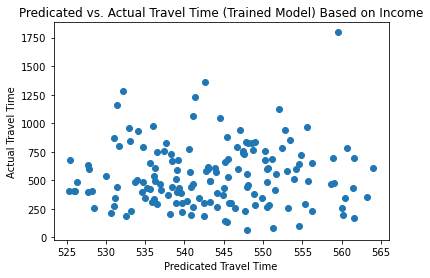

In [111]:
#poor performing model
plt.scatter(y_fitted1, y_train1);
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time")
plt.title("Predicated vs. Actual Travel Time (Trained Model) Based on Income");

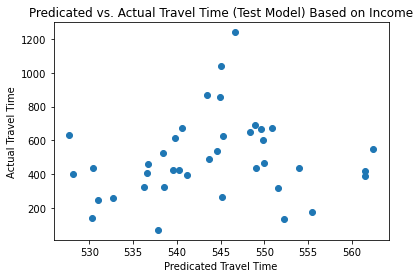

In [112]:
plt.scatter(y_predicted1, y_test1);
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time")
plt.title("Predicated vs. Actual Travel Time (Test Model) Based on Income");

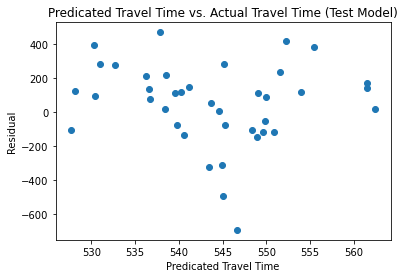

In [113]:
residuals = y_predicted1 - y_test1
plt.scatter(y_predicted1, residuals);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Residual");

In [114]:
confidence_interval = ci_regression(tract_time_income, coeff, confidence=95, m=1000)
confidence_interval

(-0.001157652441804163, 0.0005469269791131945)

Text(0, 0.5, 'Count')

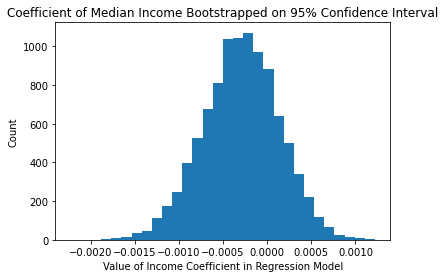

In [115]:
bootstrap_dist(tract_time_income, coeff)
plt.title("Coefficient of Median Income Bootstrapped on 95% Confidence Interval")
plt.xlabel("Value of Income Coefficient in Regression Model")
plt.ylabel("Count")

In [116]:
confidence_interval = ci_regression(tract_time_income, corr_coeff, confidence=95, m=1000)
confidence_interval

(-0.18649788973060263, 0.09901523915955975)

Text(0, 0.5, 'Count')

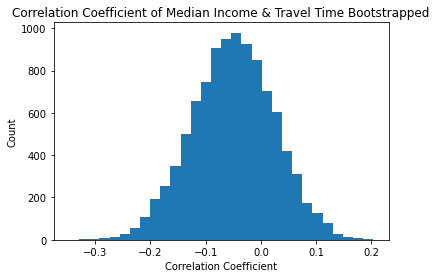

In [117]:
bootstrap_dist(tract_time_income, corr_coeff)
plt.title("Correlation Coefficient of Median Income & Travel Time Bootstrapped")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

**Exploring Population as a Feature**

Add population information by census tract

In [118]:
pop = pd.read_csv("data/sf_pop.csv")
pop

,TRACTS,Total population,Hispanic or Latino,"Total population, not Hispanic or Latino",One race total,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some Other Race,Two or More Races
0,"Census Tract 101, San Francisco County, Califo...",3739,286,3453,3601,1858,256,7,1345,23,112,138
1,"Census Tract 102, San Francisco County, Califo...",4143,211,3932,4005,3518,28,6,419,6,28,138
2,"Census Tract 103, San Francisco County, Califo...",3852,198,3654,3739,2460,36,5,1176,4,58,113
3,"Census Tract 104, San Francisco County, Califo...",4545,239,4306,4396,3014,46,4,1270,7,55,149
4,"Census Tract 105, San Francisco County, Califo...",2685,155,2530,2625,1756,46,3,778,2,40,60
...,...,...,...,...,...,...,...,...,...,...,...,...
192,"Census Tract 9804.01, San Francisco County, Ca...",0,0,0,0,0,0,0,0,0,0,0
193,"Census Tract 9805.01, San Francisco County, Ca...",797,152,645,774,87,102,7,460,39,79,23
194,"Census Tract 9806, San Francisco County, Calif...",467,60,407,442,69,266,6,84,1,16,25
195,"Census Tract 9809, San Francisco County, Calif...",350,81,269,333,215,38,1,30,2,47,17


In [119]:
import re
tract_names = []
for name in pop["TRACTS"]:
    new_name = re.findall(r"(.+\d+)", name)
    tract_names.extend(new_name)

In [120]:
pop["TRACTS"] = tract_names
only_pop = pop[["TRACTS", "Total population"]]
only_pop

,TRACTS,Total population
0,Census Tract 101,3739
1,Census Tract 102,4143
2,Census Tract 103,3852
3,Census Tract 104,4545
4,Census Tract 105,2685
...,...,...
192,Census Tract 9804.01,0
193,Census Tract 9805.01,797
194,Census Tract 9806,467
195,Census Tract 9809,350


In [121]:
master_table = tract_time_income.merge(only_pop, how="inner", left_on="name", right_on="TRACTS")
master_table

,geometry,Destination Movement ID,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds,name,median income,origin geometry,distances,TRACTS,Total population
0,POINT (-122.41635 37.78585),9,253.777778,173.222222,372.444444,199.222222,Census Tract 122.01,67569.0,POINT (-122.42289 37.77715),0.010877,Census Tract 122.01,4567
1,POINT (-122.41850 37.78797),20,228.888889,156.111111,336.222222,180.111111,Census Tract 120,51788.0,POINT (-122.42289 37.77715),0.011676,Census Tract 120,3833
2,POINT (-122.43914 37.80226),21,472.200000,401.533333,556.000000,154.466667,Census Tract 126.01,149485.0,POINT (-122.42289 37.77715),0.029912,Census Tract 126.01,2329
3,POINT (-122.39778 37.72542),44,643.083333,470.250000,968.583333,498.333333,Census Tract 233,60104.0,POINT (-122.42289 37.77715),0.057507,Census Tract 233,2624
4,POINT (-122.38621 37.72779),78,755.222222,611.222222,934.666667,323.444444,Census Tract 232,81958.0,POINT (-122.42289 37.77715),0.061492,Census Tract 232,4582
...,...,...,...,...,...,...,...,...,...,...,...,...
187,POINT (-122.36913 37.72431),2629,856.000000,697.000000,1050.000000,353.000000,Census Tract 9806,66042.0,POINT (-122.42289 37.77715),0.075379,Census Tract 9806,467
188,POINT (-122.39011 37.72164),2643,651.000000,532.500000,796.700000,264.200000,Census Tract 234,51971.0,POINT (-122.42289 37.77715),0.064467,Census Tract 234,3660
189,POINT (-122.40763 37.74398),2673,342.444444,259.111111,451.777778,192.666667,Census Tract 251,159375.0,POINT (-122.42289 37.77715),0.036518,Census Tract 251,3077
190,POINT (-122.43027 37.78791),2694,254.277778,174.444444,371.611111,197.166667,Census Tract 152,101475.0,POINT (-122.42289 37.77715),0.013049,Census Tract 152,3934


In [122]:
#correlation between population and travel time
slope, intercept, r_value, p_value, std_err = stats.linregress(master_table["Total population"], master_table["Mean Travel Time (Seconds)"])
p_value, np.corrcoef(master_table["Total population"], master_table["Mean Travel Time (Seconds)"])[0][1]
p_value

0.13613052543798515

In [123]:
#baseline linear model for using income as a feature to predict travel time
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(master_table[["Total population"]], master_table["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

linear_model_1 = lm.LinearRegression(fit_intercept=True)

m1 = linear_model_1.fit(X_train1, y_train1)

In [124]:
y_fitted1 = m1.predict(X_train1)
y_predicted1 = m1.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = linear_model_1.intercept_
theta11 = linear_model_1.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 269.28766272785884
Test RMSE: 261.3474296406746

Baseline Model
θ0: 461.4488736578422
θ1: 0.019434336739881253


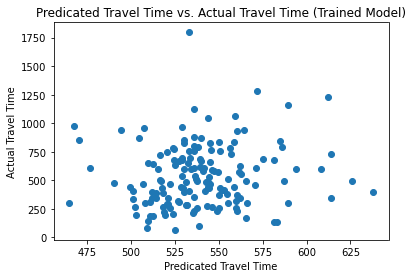

In [125]:
#poor performing model
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

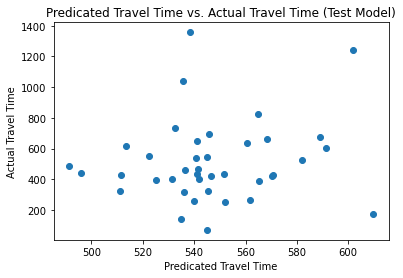

In [126]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

Exploring population density

In [127]:
# Load area of census tract data SF = county 75 

tract_area_load = pd.read_html("data/Census_Tract_Area.html")
tract_area = tract_area_load[0].drop(columns=['MTFCC', 'OID', 'GEOID', 'LSADC', 'STATE', 'FUNCSTAT', 'AREAWATER', 'UR', 'CENTLAT', 'CENTLON', 'INTPTLAT', 'INTPTLON', 'BASENAME'])

tract_area_sf = tract_area.loc[tract_area['COUNTY'] == 75]
tract_area_sf

,COUNTY,TRACT,NAME,AREALAND
7057,75,10101,Census Tract 101.01,696934.0
7058,75,10102,Census Tract 101.02,79556.0
7059,75,10201,Census Tract 102.01,186873.0
7060,75,10202,Census Tract 102.02,332254.0
7061,75,10300,Census Tract 103,268261.0
...,...,...,...,...
7296,75,980501,Census Tract 9805.01,1471536.0
7297,75,980600,Census Tract 9806,2132298.0
7298,75,980900,Census Tract 9809,3602295.0
7299,75,990100,Census Tract 9901,NaN


In [128]:
master_table2 = master_table.merge(tract_area_sf, how="inner", left_on="TRACTS", right_on="NAME")
master_table2

,geometry,Destination Movement ID,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds,name,median income,origin geometry,distances,TRACTS,Total population,COUNTY,TRACT,NAME,AREALAND
0,POINT (-122.43914 37.80226),21,472.200000,401.533333,556.000000,154.466667,Census Tract 126.01,149485.0,POINT (-122.42289 37.77715),0.029912,Census Tract 126.01,2329,75,12601,Census Tract 126.01,170458.0
1,POINT (-122.39778 37.72542),44,643.083333,470.250000,968.583333,498.333333,Census Tract 233,60104.0,POINT (-122.42289 37.77715),0.057507,Census Tract 233,2624,75,23300,Census Tract 233,633256.0
2,POINT (-122.38621 37.72779),78,755.222222,611.222222,934.666667,323.444444,Census Tract 232,81958.0,POINT (-122.42289 37.77715),0.061492,Census Tract 232,4582,75,23200,Census Tract 232,856567.0
3,POINT (-122.43735 37.78129),80,284.833333,205.277778,395.944444,190.666667,Census Tract 158.01,88636.0,POINT (-122.42289 37.77715),0.015046,Census Tract 158.01,3594,75,15801,Census Tract 158.01,343934.0
4,POINT (-122.43927 37.74019),81,788.666667,651.500000,957.666667,306.166667,Census Tract 217,160417.0,POINT (-122.42289 37.77715),0.040424,Census Tract 217,3948,75,21700,Census Tract 217,1236558.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,POINT (-122.40689 37.71122),2625,607.500000,475.000000,807.083333,332.083333,Census Tract 264.03,80250.0,POINT (-122.42289 37.77715),0.067841,Census Tract 264.03,4140,75,26403,Census Tract 264.03,379501.0
150,POINT (-122.36913 37.72431),2629,856.000000,697.000000,1050.000000,353.000000,Census Tract 9806,66042.0,POINT (-122.42289 37.77715),0.075379,Census Tract 9806,467,75,980600,Census Tract 9806,2132298.0
151,POINT (-122.39011 37.72164),2643,651.000000,532.500000,796.700000,264.200000,Census Tract 234,51971.0,POINT (-122.42289 37.77715),0.064467,Census Tract 234,3660,75,23400,Census Tract 234,858134.0
152,POINT (-122.40763 37.74398),2673,342.444444,259.111111,451.777778,192.666667,Census Tract 251,159375.0,POINT (-122.42289 37.77715),0.036518,Census Tract 251,3077,75,25100,Census Tract 251,552278.0


In [129]:
master_table2["population density"] = master_table2["Total population"] / master_table2["AREALAND"]
master_table2

,geometry,Destination Movement ID,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Difference in Bounds,name,median income,origin geometry,distances,TRACTS,Total population,COUNTY,TRACT,NAME,AREALAND,population density
0,POINT (-122.43914 37.80226),21,472.200000,401.533333,556.000000,154.466667,Census Tract 126.01,149485.0,POINT (-122.42289 37.77715),0.029912,Census Tract 126.01,2329,75,12601,Census Tract 126.01,170458.0,0.013663
1,POINT (-122.39778 37.72542),44,643.083333,470.250000,968.583333,498.333333,Census Tract 233,60104.0,POINT (-122.42289 37.77715),0.057507,Census Tract 233,2624,75,23300,Census Tract 233,633256.0,0.004144
2,POINT (-122.38621 37.72779),78,755.222222,611.222222,934.666667,323.444444,Census Tract 232,81958.0,POINT (-122.42289 37.77715),0.061492,Census Tract 232,4582,75,23200,Census Tract 232,856567.0,0.005349
3,POINT (-122.43735 37.78129),80,284.833333,205.277778,395.944444,190.666667,Census Tract 158.01,88636.0,POINT (-122.42289 37.77715),0.015046,Census Tract 158.01,3594,75,15801,Census Tract 158.01,343934.0,0.010450
4,POINT (-122.43927 37.74019),81,788.666667,651.500000,957.666667,306.166667,Census Tract 217,160417.0,POINT (-122.42289 37.77715),0.040424,Census Tract 217,3948,75,21700,Census Tract 217,1236558.0,0.003193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,POINT (-122.40689 37.71122),2625,607.500000,475.000000,807.083333,332.083333,Census Tract 264.03,80250.0,POINT (-122.42289 37.77715),0.067841,Census Tract 264.03,4140,75,26403,Census Tract 264.03,379501.0,0.010909
150,POINT (-122.36913 37.72431),2629,856.000000,697.000000,1050.000000,353.000000,Census Tract 9806,66042.0,POINT (-122.42289 37.77715),0.075379,Census Tract 9806,467,75,980600,Census Tract 9806,2132298.0,0.000219
151,POINT (-122.39011 37.72164),2643,651.000000,532.500000,796.700000,264.200000,Census Tract 234,51971.0,POINT (-122.42289 37.77715),0.064467,Census Tract 234,3660,75,23400,Census Tract 234,858134.0,0.004265
152,POINT (-122.40763 37.74398),2673,342.444444,259.111111,451.777778,192.666667,Census Tract 251,159375.0,POINT (-122.42289 37.77715),0.036518,Census Tract 251,3077,75,25100,Census Tract 251,552278.0,0.005571


In [130]:
#correlation between population density and travel time
slope, intercept, r_value, p_value, std_err = stats.linregress(master_table2["population density"], master_table2["Mean Travel Time (Seconds)"])
p_value, np.corrcoef(master_table2["population density"], master_table2["Mean Travel Time (Seconds)"])[0][1]
a = np.corrcoef(master_table2["distances"], master_table2["Mean Travel Time (Seconds)"])[0][1]
p_value

1.0164530692172759e-06

In [131]:
#baseline linear model for using income as a feature to predict travel time

X_train1, X_test1, y_train1, y_test1 = train_test_split(master_table2[["population density"]], master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

linear_model_1 = lm.LinearRegression(fit_intercept=True)

m1 = linear_model_1.fit(X_train1, y_train1)

In [132]:
y_fitted1 = m1.predict(X_train1)
y_predicted1 = m1.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = linear_model_1.intercept_
theta11 = linear_model_1.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 234.68122142543425
Test RMSE: 307.09008695159366

Baseline Model
θ0: 703.1191454376675
θ1: -12747.670265031265


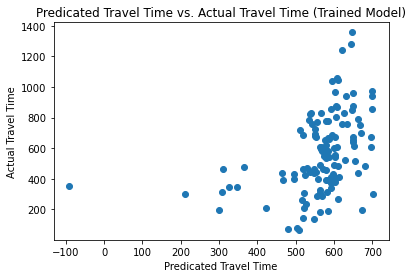

In [133]:
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

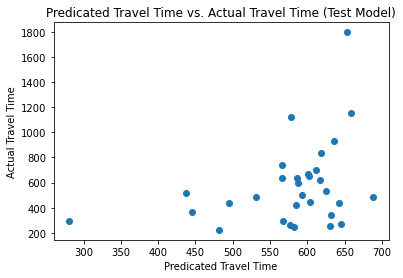

In [134]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

**Slightly Improved Model**

Population Density and Income Multiple Linear Regression

In [135]:
def variables(data, list_of_variables):
    variables = []
    for i in np.arange(len(data)):
        v = []
        for x in list_of_variables:
            v.append(data[x][i])
        variables.append(v)
    return variables

In [136]:
income_popdens = variables(master_table2, ["median income", "population density"])

In [137]:
#model using median income and population density
X_train1, X_test1, y_train1, y_test1 = train_test_split(income_popdens, master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

model = LinearRegression(fit_intercept=True)
model.fit(X_train1, y_train1)

training_accuracy = model.score(X_train1, y_train1)
testing_accuracy = model.score(X_test1, y_test1)
print("Training Accuracy: ", training_accuracy)
print("Testing Accuracy: ", testing_accuracy)

Training Accuracy:  0.19595585773507063
Testing Accuracy:  0.24264737413609871


In [138]:
y_fitted1 = model.predict(X_train1)
y_predicted1 = model.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = model.intercept_
theta11 = model.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 229.7429521752101
Test RMSE: 282.7259372230696

Baseline Model
θ0: 857.7358794319755
θ1: -0.0011514167017119068


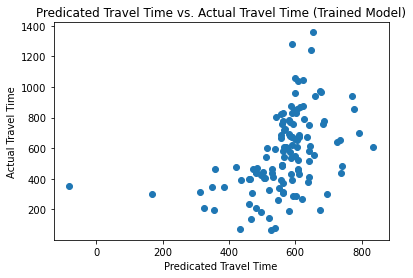

In [139]:
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

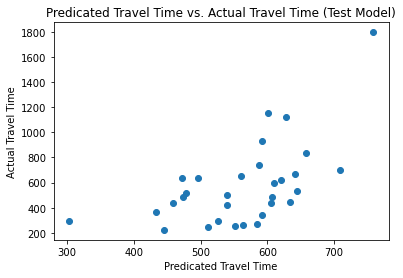

In [140]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

**Exploring distance as a feature**

In [141]:
#correlation between distance and travel time
slope, intercept, r_value, p_value, std_err = stats.linregress(master_table2["distances"], master_table2["Mean Travel Time (Seconds)"])
p_value, np.corrcoef(master_table2["distances"], master_table2["Mean Travel Time (Seconds)"])[0][1]
p_value

8.062542023581578e-36

In [142]:
#baseline linear model for using income as a feature to predict travel time

X_train1, X_test1, y_train1, y_test1 = train_test_split(master_table2[["population density"]], master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

linear_model_1 = lm.LinearRegression(fit_intercept=True)

m1 = linear_model_1.fit(X_train1, y_train1)

In [143]:
y_fitted1 = m1.predict(X_train1)
y_predicted1 = m1.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = linear_model_1.intercept_
theta11 = linear_model_1.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 234.68122142543425
Test RMSE: 307.09008695159366

Baseline Model
θ0: 703.1191454376675
θ1: -12747.670265031265


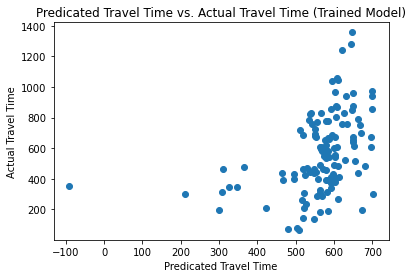

In [144]:
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

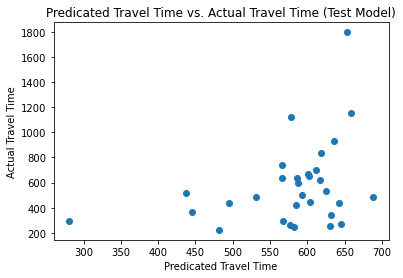

In [145]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

**Improved Model with Added Features**

Median income, population density, distance

In [146]:
#model using median income, population density, distance
X_train1, X_test1, y_train1, y_test1 = train_test_split(variables(master_table2, ["median income", "population density", "distances"]), master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

model = LinearRegression(fit_intercept=True)
model.fit(X_train1, y_train1)

training_accuracy = model.score(X_train1, y_train1)
testing_accuracy = model.score(X_test1, y_test1)
print("Training Accuracy: ", training_accuracy)
print("Testing Accuracy: ", testing_accuracy)

Training Accuracy:  0.7045865932484301
Testing Accuracy:  0.5177340770164196


In [147]:
y_fitted1 = model.predict(X_train1)
y_predicted1 = model.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Improved Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = model.intercept_
theta11 = model.coef_[0]
print("Improved Model\nθ0: {}\nθ1: {}".format(theta01, theta11))
model.score(X_train1, y_train1)

Improved Model
Training RMSE: 139.25710157969027
Test RMSE: 225.61079323214432

Improved Model
θ0: -29.432219328365818
θ1: 0.001006720563368848


0.7045865932484301

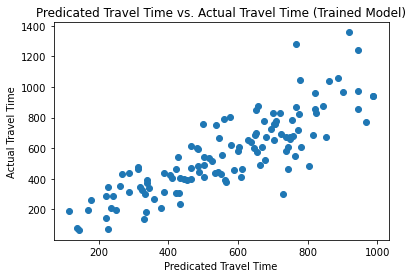

In [148]:
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

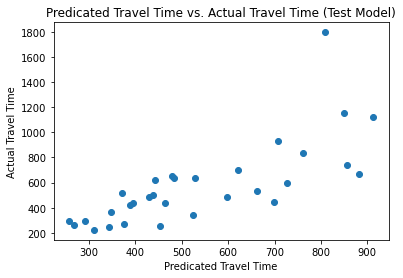

In [149]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

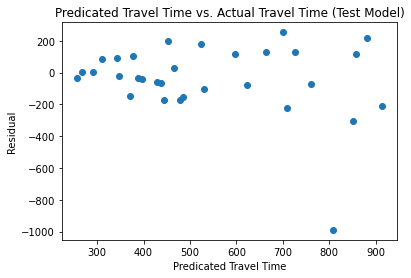

In [150]:
residuals = y_predicted1 - y_test1
plt.scatter(y_predicted1, residuals);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Residual");

**Exploring Regularization**

In [151]:
#Will use lasso/ridge regularization to prevent overfitting 
lasso = lm.Lasso(alpha = 0.01)
lasso.fit(X_train1, y_train1)

y_fitted1 = lasso.predict(X_train1)
y_predicted1 = lasso.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Lasso Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))
lasso.score(X_train1, y_train1), lasso.score(X_test1, y_test1)
#We see a very slight improvement, nearly none, compared to our final imporoved model above

Lasso Model
Training RMSE: 139.27142359115757
Test RMSE: 225.53026319854303



(0.7045258260528324, 0.5180782977796367)

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

**Population Density**

Exploring log population density

In [152]:
master_table2["log population density"] = np.log(master_table2["population density"])

In [153]:
#correlation between population density and travel time
slope, intercept, r_value, p_value, std_err = stats.linregress(master_table2["log population density"], master_table2["Mean Travel Time (Seconds)"])
p_value, np.corrcoef(master_table2["log population density"], master_table2["Mean Travel Time (Seconds)"])[0][1]
a = np.corrcoef(master_table2["distances"], master_table2["Mean Travel Time (Seconds)"])[0][1]
p_value

6.941405102499174e-05

In [154]:
#log population density and travel time model

X_train1, X_test1, y_train1, y_test1 = train_test_split(master_table2[["log population density"]], master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

linear_model_1 = lm.LinearRegression(fit_intercept=True)

m1 = linear_model_1.fit(X_train1, y_train1)

In [155]:
y_fitted1 = m1.predict(X_train1)
y_predicted1 = m1.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = linear_model_1.intercept_
theta11 = linear_model_1.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 242.26205955079058
Test RMSE: 311.84769468854273

Baseline Model
θ0: 154.20804380069308
θ1: -85.20375335281217


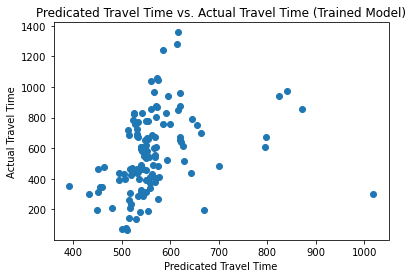

In [156]:
#poor performing model
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

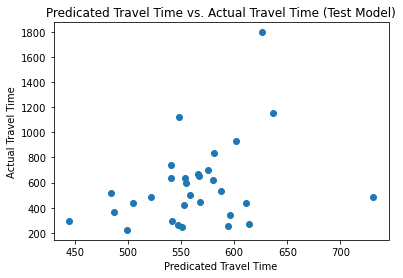

In [157]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

Exploring population density squared

In [158]:
master_table2["population density^2"] = master_table2["population density"]**2

In [159]:
#correlation between population density and travel time
slope, intercept, r_value, p_value, std_err = stats.linregress(master_table2["population density^2"], master_table2["Mean Travel Time (Seconds)"])
p_value, np.corrcoef(master_table2["population density^2"], master_table2["Mean Travel Time (Seconds)"])[0][1]
p_value

0.0016574184499788464

In [160]:
#population density squared and travel time model

X_train1, X_test1, y_train1, y_test1 = train_test_split(master_table2[["population density^2"]], master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

linear_model_1 = lm.LinearRegression(fit_intercept=True)

m1 = linear_model_1.fit(X_train1, y_train1)

In [161]:
y_fitted1 = m1.predict(X_train1)
y_predicted1 = m1.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = linear_model_1.intercept_
theta11 = linear_model_1.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 247.33332438947033
Test RMSE: 316.97059932608727

Baseline Model
θ0: 595.4742679151011
θ1: -165981.06322151067


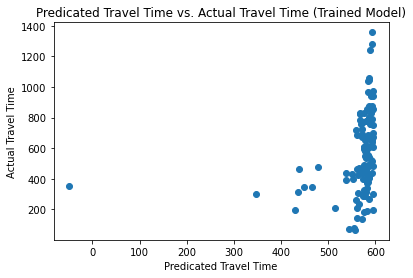

In [162]:
#poor performing model
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

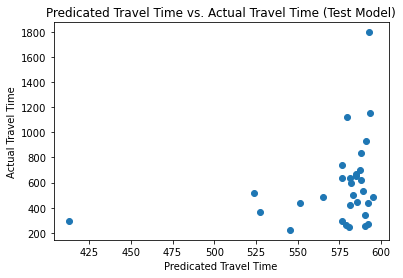

In [163]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

**Median Income**

Exploring log median income

In [167]:
master_table2["log median income"] = np.log(master_table2["median income"])

In [168]:
#correlation between population density and travel time
slope, intercept, r_value, p_value, std_err = stats.linregress(master_table2["log median income"], master_table2["Mean Travel Time (Seconds)"])
p_value, np.corrcoef(master_table2["log median income"], master_table2["Mean Travel Time (Seconds)"])[0][1]
p_value

0.1910173523985823

In [169]:
#log population density and travel time model

X_train1, X_test1, y_train1, y_test1 = train_test_split(master_table2[["log median income"]], master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

linear_model_1 = lm.LinearRegression(fit_intercept=True)

m1 = linear_model_1.fit(X_train1, y_train1)

In [170]:
y_fitted1 = m1.predict(X_train1)
y_predicted1 = m1.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = linear_model_1.intercept_
theta11 = linear_model_1.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 256.202932508419
Test RMSE: 324.1663673074192

Baseline Model
θ0: 618.4346798397612
θ1: -4.602240989405387


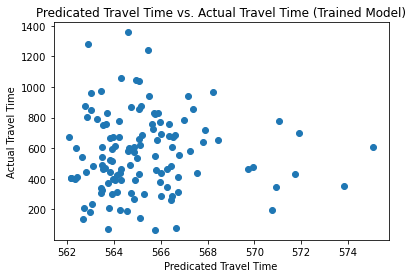

In [171]:
#poor performing model
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

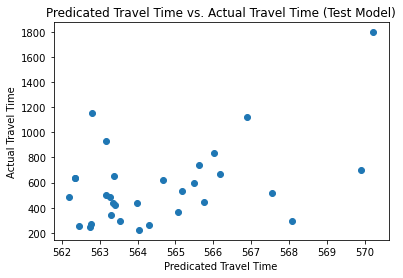

In [172]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

Exploring median income squared

In [173]:
master_table2["median income^2"] = master_table2["median income"]**2

In [174]:
#correlation between population density and travel time
slope, intercept, r_value, p_value, std_err = stats.linregress(master_table2["median income^2"], master_table2["Mean Travel Time (Seconds)"])
p_value, np.corrcoef(master_table2["median income^2"], master_table2["Mean Travel Time (Seconds)"])[0][1]
p_value

0.11670049049582139

In [175]:
#log population density and travel time model

X_train1, X_test1, y_train1, y_test1 = train_test_split(master_table2[["median income^2"]], master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

linear_model_1 = lm.LinearRegression(fit_intercept=True)

m1 = linear_model_1.fit(X_train1, y_train1)

In [176]:
y_fitted1 = m1.predict(X_train1)
y_predicted1 = m1.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Baseline Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = linear_model_1.intercept_
theta11 = linear_model_1.coef_[0]
print("Baseline Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Baseline Model
Training RMSE: 255.6350350906219
Test RMSE: 319.92781186174204

Baseline Model
θ0: 590.8557951221584
θ1: -1.684205875507407e-09


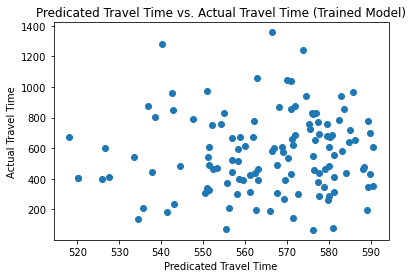

In [177]:
#poor performing model
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

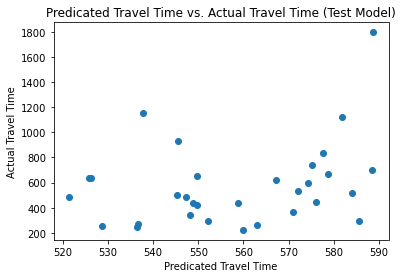

In [178]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

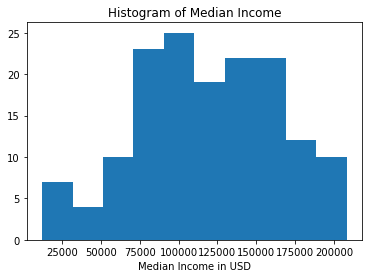

In [179]:
plt.hist(master_table2["median income"]);
plt.title("Histogram of Median Income")
plt.xlabel("Median Income in USD");

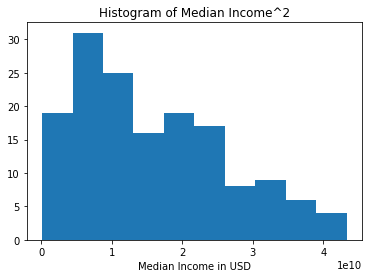

In [180]:
plt.hist(master_table2["median income^2"]);
plt.title("Histogram of Median Income^2")
plt.xlabel("Median Income in USD");

**Models**

Median income squared, log population density, distance

In [181]:
#model using median income squared, population density, distance
X_train1, X_test1, y_train1, y_test1 = train_test_split(variables(master_table2, ["median income^2", "log population density", "distances"]), master_table2["Mean Travel Time (Seconds)"], test_size=0.2, random_state=42)

model = LinearRegression(fit_intercept=True)
model.fit(X_train1, y_train1)

training_accuracy = model.score(X_train1, y_train1)
testing_accuracy = model.score(X_test1, y_test1)
print("Training Accuracy: ", training_accuracy)
print("Testing Accuracy: ", testing_accuracy)

Training Accuracy:  0.7134931890703033
Testing Accuracy:  0.5330336223337924


In [182]:
y_fitted1 = model.predict(X_train1)
y_predicted1 = model.predict(X_test1)

training_error1 = rmse(y_fitted1, y_train1)
test_error1 = rmse(y_predicted1, y_test1)
print("Improved Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error1, test_error1))

theta01 = model.intercept_
theta11 = model.coef_[0]
print("Improved Model\nθ0: {}\nθ1: {}".format(theta01, theta11))

Improved Model
Training RMSE: 137.1417624977421
Test RMSE: 222.00327976239106

Improved Model
θ0: 148.1272173565551
θ1: 4.687927477835408e-09


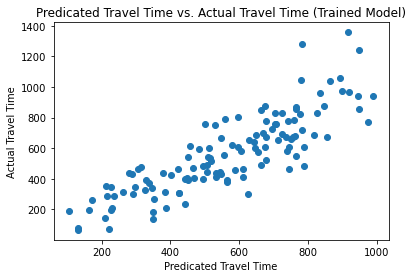

In [183]:
plt.scatter(y_fitted1, y_train1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Trained Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

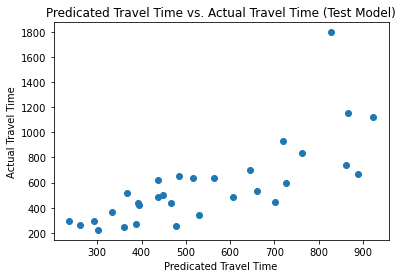

In [184]:
plt.scatter(y_predicted1, y_test1);
plt.title("Predicated Travel Time vs. Actual Travel Time (Test Model)")
plt.xlabel("Predicated Travel Time")
plt.ylabel("Actual Travel Time");

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [185]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results:
    q4ai2 - 1 result:
        Trying:
            answer[0].shape == (5900, 10)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai2 0
        Failed example:
            answer[0].shape == (590

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()